# Analysis of usage of the term "sygeplejersker" in DR, TV2 and the danish parliament

## Extract content of zip

## Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import re
import time
import tqdm
import zipfile
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
import itertools

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

# Scraping
import requests
from bs4 import BeautifulSoup as bs
import os
import lxml
from lxml import objectify
import ftplib
from io import BytesIO

#Text processing
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from PIL import Image
nltk.download("punkt")
from sentida import Sentida # sentida

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jgb569\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ModuleNotFoundError: No module named 'sentida'

## Data gathering

### DR

> NOTE: The following code must be run on a computer with danish language as google behaves differently based on the computers language settings

#### 1:  Generate search terms

Search terms follow the following format: We search for the month and year in the format DR articles inclue a timestap. Manual Google searches proved to provide relevant research results mostly limited to the month provided. In this way we create a list of links to DR articles. All articles are located on the site https://www.dr.dk/nyheder or a subsite. This can be included in the google search. An example of a search is: jan. 2012" AND "sygeplejersker*" site:https://www.dr.dk/nyheder.

In [2]:
# Generate empty list with search terms
search_terms = []
# Generate combinations of year-month and term search combinations
for year in range(2012, 2023):
    months = ['jan.', 'feb.', 'mar.', 'apr.', 'maj', 'jun.', 'jul.', 'aug.', 'sep.', 'okt.', 'nov.', 'dec.']
    for month in months:
        term = f'"{month} {year}" AND "sygeplejersker*" site:https://www.dr.dk/nyheder/ \n'
        search_terms.append(term)
# Create final list of search terms, future month-year combinations deleted
search_terms = search_terms[:-4]

We create a total of 124 search terms, for all month-year combinations between January 2012 and August 2022.

#### 2a: Scraping Google search to retrieve list of links to DR articles
With the following code we scrape Google searches to retrieve a list of links to DR articles, given the DR website does not provide a useful search function. We use Selenium to go execute a Google search and retrieve DR article links. We execute the search, save the HTML for the first results page and then go to further pages of the search results to retrieve more search resutls. Google intervenes when scaping search results too fast. We therefore integrate a break when moving between pages. The break time takes random values between 0.25 and 3.5 seconds.

Scraping the first three search pages:

In [3]:
driver = webdriver.Chrome(ChromeDriverManager().install())
html_list = []
finished_searches = 0

for i in tqdm.tqdm(search_terms[0:1]):
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(i)
    # Get HTML for first search result page
    html = driver.page_source
    html_list.append(html)
    # Go to next result page
    next_page = driver.find_element(By.CSS_SELECTOR, ".NVbCr+ span") #CSS selector only last not previous page
    next_page.click()
    # Define an error used when reaching last search page:
        # When error = 0, there is another resut page.
        # When error = 1, there is no further page on Google, loop stops.
    error = 0
    page = 1
    for page in range(0,1): #Iterates over 3 Pages in total
        try:
            html2 = driver.page_source
            html_list.append(html2)
            # Google detects suspicious behavior and asks to solve some puzzle after 7 iterations. Trying random sleep time and scrolling down to element.
            time.sleep(np.random.uniform(10, 15))
            # Go to next result page
            next_page = driver.find_element(By.CSS_SELECTOR, "#pnnext .NVbCr+ span") #CSS selector only last not previous page
            next_page.click()
            page += 1
        except:
            error += 1
    finished_searches += 1
    time.sleep(np.random.uniform(5,10))
    driver.quit()

C:\Users\jgb569\AppData\Local\Temp/ipykernel_20092/3444555280.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
100%|██████████| 1/1 [00:26<00:00, 26.60s/it]


#### 2b: Scraping number of google results for search terms

In [7]:
num_search_results = []

for search_term in tqdm.tqdm(search_terms[0:1]):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(search_term)
    # Get HTML for first search result page
    num_results = driver.find_element(By.ID, "result-stats")
    num_search_results.append(num_results.text)
    time.sleep(np.random.uniform(0.25,1))
    driver.quit()

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\jgb569\AppData\Local\Temp/ipykernel_20092/505961433.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
100%|██████████| 1/1 [00:06<00:00,  6.97s/it]


In [8]:
# Create list of search result counts
num_search_results_clean = []
for result in num_search_results:
    number_only = result[3:10]
    number_only = number_only.strip()
    number_only = re.sub('\D+', '', number_only)
    num_search_results_clean.append(number_only)

In [10]:
# Change to integer
list_search_results = [int(search) for search in num_search_results_clean]

In [11]:
# Creating a pd.DataFrame from search result count
list_search_results_df = pd.DataFrame({'Month': list_search_results}) # 'MONTH' SHOULD BE 'SEARCH_RESULTS'!

In [12]:
# Export 
list_search_results_df.to_csv("dr_google_search_results_sample.csv")

#### 3: Create link list

In [13]:
# Preparing two empty lists
link_list = []
link_list_clean = []
# Iterating over the results from scraping
for l in html_list:
    soup = bs(l, 'lxml')
    try: 
        links = soup.find('div', class_ = 'v7W49e').find_all('a', href=True)
    except:
        pass
    # Generate list with all links
    for i in links:
        temp = i['href']
        link_list.append(temp)
    # Getting rid of noise, links not pointing to DR but Google infrastructure
    for link in link_list:
        if "webcache.googleusercontent" not in link:
            link_list_clean.append(link)

#### 4: From list to DataFrame

In [14]:
# Creating a pd.DataFrame from link_list_clean
dr_links = pd.DataFrame({'links':link_list_clean})
# For some reason, there are many duplicates included, drop them
dr_links = dr_links.drop_duplicates(subset = 'links')

In [15]:
# Defining empty list for features
dr_titles_list = []
dr_h2_list = []
dr_date = []
dr_content_list = []
dr_author_list = []
dr_subhead_list = []
dr_tag_list = []

# Looping over links to retrieve HTMLs and extract relevant information from webpages
for u in tqdm.tqdm(dr_links["links"]):
    re = requests.get(u, headers = {"Name" : "Simon Ullrich - summer course project" , "email": "simon.ullrich@sodas.ku.dk"})
    soup = bs(re.content, "lxml")
    # Extracting article titles
    try:
        title = soup.find("div", class_ = "dre-speech")
        dr_titles_list.append(title.text)
    except:
        dr_titles_list.append("")
    # Extracting date of publication
    try:
        try:
            date = soup.find("time", class_ = "dre-byline__date")['datetime']
            dr_date.append(date)
        # Some websites are of another type. Date of publication located elsewhere on the website
        except:
            # Different website type: e.g. https://www.dr.dk/nyheder/da-lille-rikke-loeb-ind-i-margrethe
            date = soup.find("div", class_ = "hydra-latest-news-page-short-news__top").find("span", class_ = "dre-label-text__text")
            dr_date.append(pd.to_datetime(date.text))
    except:
        dr_date.append("")
    # Extracting author of articles
    try:
        author = soup.find("div", class_ = "dre-byline__contribution-details")
        dr_author_list.append(author.text)
    except:
        dr_author_list.append("")
    # Extracting subheaders
    try:
        subheader = soup.find("p", class_ = "dre-article-title__summary")
        dr_subhead_list.append(subheader.text)
    except:
        dr_subhead_list.append("")
    # Extracting article bodies
    try:
        # try:
        dr_content_i_list = []
        dr_content = soup.find_all("p", class_ = "dre-article-body-paragraph dre-variables")
        for i in dr_content:
            dr_content_i_list.append(i.text)
        dr_content_str = " ".join(dr_content_i_list)
        dr_content_list.append(dr_content_str)
        # except:
            # dr_content_i_list = []
            # dr_content = soup.find("div", class_ = "hydra-latest-news-page-short-news__body")
            # for i in dr_content:
                # dr_content_i_list.append(i)
                # dr_content_str = " ".join(dr_content_i_list)
            # dr_content_list.append(dr_content_str)
    except:
        dr_content_list.append("")
    # Extracting second headlines
    try:
        dr_h2 = soup.find_all("h2", class_ = "dre-article-body-sub-heading dre-variables")
        dr_h2_i_list = []
        for i in dr_h2:
            dr_h2_i = i.get_text()
            dr_h2_i_list.append(dr_h2_i)
        dr_h2_str = " ".join(dr_h2_i_list)
        dr_h2_list.append(dr_h2_str)
    except:
        dr_h2_list.append("")
    # Extracting article tags
    try:
        dr_tag = soup.find("a", class_ = "dre-article-title-section-label__title dre-article-title-section-label__title--link")
        dr_tag_list.append(dr_tag.text)
    except:
        dr_tag_list.append("")

100%|██████████| 20/20 [01:51<00:00,  5.56s/it]


In [21]:
### Combine lists to DataFrame
dr_articles_sample=pd.DataFrame([dr_titles_list, dr_subhead_list, dr_h2_list, dr_content_list, dr_author_list, dr_tag_list, dr_date, link_list_clean]).transpose()
dr_articles_sample.columns=["titles", "sub_header", "h2", "content", "author", "tag", "date", "link"]
dr_articles_sample["source"] = "DR"

display(dr_articles_sample)

,titles,sub_header,h2,content,author,tag,date,link,source
0,Danske sygeplejersker får job i Norge,"Krise, fyringer og ansættelsesstop får sygeple...",Markant flere,"Antallet af danske sygeplejersker, der har fåe...",Ritzau/,Penge,2012-01-19 13:27:00+00:00,https://www.dr.dk/nyheder/penge/danske-sygeple...,DR
1,Næsten ingen ledige sygeplejersker,Trods fyringsrunder i både 2010 og 2011 er arb...,,Trods fyringsrunder på sygehusene i både 2010 ...,Henny Mortensen,Sjælland,2012-01-28 07:42:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR
2,BILLEDSERIE: Den nye dronning,,,,Ida Meesenburg,,2012-01-08 00:00:00+00:00,https://www.dr.dk/Nyheder/Temaer/2012/Dronning...,DR
3,Socialminister: Vi kommer til at lære af Rebil...,Socialminister Karen Hækkerup er overbevist om...,,Socialminister Karen Hækkerup er overbevist om...,Søren K Nielsen,Nordjylland,2012-01-17 21:42:00+00:00,https://www.dr.dk/nyheder/regionale/nordjyllan...,DR
4,To døde af legionærsyge,To ældre koldingensere er døde af legionærsyge...,,To ældre koldingensere er døde af legionærsyge...,Jan Laursen,Trekantområdet,2012-01-13 05:36:25+00:00,https://www.dr.dk/nyheder/regionale/trekanten/...,DR
5,Regionsformand: Jeg har ikke noget at undskylde,"Steen Bach Nielsen forstår ikke, at sygeplejer...",,Der er ikke noget at undskylde eller beklage.....,Jørgen Hansen,Sjælland,2012-01-24 15:39:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR
6,Hjælp syge til at finde vej i labyrinten,Behandlingsgarantier og sygehus-omdannelser kr...,,Sygehusvæsenet er een stor labyrint for mange ...,Henny Mortensen,Sjælland,2012-01-12 12:25:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR
7,BILLEDSERIE: Gallataffel på Christiansborg,,,,Morten Greve,,2012-01-15 00:00:00+00:00,https://www.dr.dk/nyheder/temaer/2012/dronning...,DR
8,Langtidsledigheden er eksploderet,"Langtidsledigheden er firedoblet, siden højkon...",,Paniske lønmodtagere med fast kurs mod tab af ...,Asger Røjle,Penge,2012-01-16 21:15:28+00:00,https://www.dr.dk/nyheder/penge/langtidsledigh...,DR
9,Noah: Noah,Duoen NOAH's singler har høstet dobbeltplatin ...,,Den unge popduo NOAH gjorde sit indtog på P4s ...,,Regionalt,2012-01-27 13:32:00+00:00,https://www.dr.dk/nyheder/regionale/noah-noah,DR


#### 5: Save sample dataset and load complete dataset

In [22]:
### Save dataset
dr_articles_sample.to_csv("dr_articles_sample.csv", index = False)

### TV2

#### 1:  Generate search terms

In [29]:
links=[]
for year in range(2012, 2023, 1):
    year=f"https://search.tv2.dk/?query=sygeplejersker+{year}"
    
    for month in range(1,10,1): #Måned 1-9
        search_month=f"-0{month}&sort=relevance&page="
        
        for page in range(1,11,1): # (start, stop, step)
            url = year+search_month+f"{page}"
            links.append(url)
    
    for month in range(10, 13): #måned 10-12
        search_month=f"-{month}&sort=relevance&page="
        
        for page in range(1,11,1): # (start, stop, step)
            url = year+search_month+f"{page}"
            links.append(url)

In [30]:
tv2_article_list=pd.DataFrame(links)
tv2_article_list.to_csv("tv2_links_to_articles.csv")

#### 2: Scraping TV2 searches for links to articles and create list

In [ ]:
article_url=[]
for i in tqdm.tqdm(links[0:2]):
    try:
        resp_page = requests.get(i, headers={"Name" : "Oliver Fredborg Smietana" , "email": "kph383@ku.alumni.dk"})
        soup = bs(resp_page.content, 'lxml')
        for link in soup.find("section").find_all('a', href=True):
            article_url.append(links['href'])
    except:
        pass
    time.sleep(0.25)

In [35]:
bs

bs4.BeautifulSoup

In [31]:
article_url=[]
for i in tqdm.tqdm(links[0:2]):
    try:
        resp_page = requests.get(i,headers={"Name" : "Oliver Fredborg Smietana" , "email": "kph383@ku.alumni.dk"})
        soup = bs(resp_page.content, 'lxml')
        for link in soup.find("section").find_all('a', href=True):
            article_url.append(links['href'])
    except:
        pass
    time.sleep(0.25)

100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


#### 3: Scraping articles from links list

In [34]:
links[0:2]

['https://search.tv2.dk/?query=sygeplejersker+2012-01&sort=relevance&page=1',
 'https://search.tv2.dk/?query=sygeplejersker+2012-01&sort=relevance&page=2']

In [24]:
titles_list=[]
h2_list=[]
date_list=[]
content_list=[]
author_list=[]
sub_head_list=[]
tag_list=[]

#  Define start and end of article loop
start=0
end=15


for u in tqdm.tqdm(article_url[start: end]) :
    re=requests.get(u, headers={"Name" : "Oliver Fredborg Smietana" , "email": "kph383@alumni.ku.dk", "Purpose": "exam project for Copenhagen uni Course" })
    soup=bs(re.content, "lxml")
    try:
        title=soup.find("h1", class_="tc_heading tc_heading--2")
        titles_list.append(title.text.strip())
    except:
        titles_list.append("")

    try:
        date=soup.find("time", class_="tc_timestamp")['datetime']
        date_list.append(date)
    except:
        date_list.append("")

    try:
        h2=soup.find_all("h2", class_="tc_heading tc_heading--2")
        h2_i_list=[]
        for i in h2:
            h2_i=i.get_text()
            h2_i_list.append(h2_i)
        h2_str=" ".join(h2_i_list)
        h2_list.append(h2_str)
    except:
        h2_list.append("")

    try:
        sub_head=soup.find("p", class_="tc_page__body__standfirst")
        sub_head_list.append(sub_head.text.strip())
    except:
        sub_head_list.append("")

    try:
        author=soup.find("span", class_="tc_byline__author__text")
        author_list.append(author.text.strip())
    except:
         author_list.append("")

    try:
        content_i_list=[]
        content_i=soup.find("div", class_="tc_richcontent").find_all("p")
        for i in content_i:
            content_i_list.append(i.text.strip())
        content_str=" ".join(content_i_list)
        content_list.append(content_str)
    except:
        content_list.append("")

    try:
        tag=soup.find("a", class_="tc_label tc_label--color-base-red")
        tag_list.append(tag.text.strip())
    except:
        tag_list.append("")

    time.sleep(0.25)



0it [00:00, ?it/s]


#### 4: Creating dataframe from scraped articles

In [37]:
tv2_articles_sample=pd.DataFrame([titles_list, sub_head_list, h2_list, content_list, author_list, tag_list, date_list, links[start:end]]).transpose()
tv2_articles_sample.columns=["titles", "sub_header", "h2", "content", "author", "tag", "date", "link"]
tv2_articles["source"]="tv2"

#### 5: Save sample dataset

In [53]:
tv2_articles.to_csv("tv2_articles_sample.csv", index=False) 

### Folketinget

#### 1: Create empty lists for loading data

In [2]:
# Empty lists for loading data
dirs = [] 
sub_dir = []
files = []
file_name = [] 
paths = []
raw_xml_list = []

# Empty lists for DataFrame creation (columns)
session = []
meetingnumber = []
date = []
location = []
group = []
content = []
path = []

#### 2: Logon to ftp server and get a list of dictionaries containing transscripted meetings in Folketinget

In [3]:
ftp_url = "oda.ft.dk"
ftp_dir = "/ODAXML/Referat/samling/"

In [4]:
ftp = ftplib.FTP(ftp_url)
ftp.login("anonymous", "wpg345@alumni.ku.dk")
ftp.set_pasv(True)
ftp.cwd(ftp_dir)
ftp.dir(dirs.append)

#### 3: Creates a list of sub-dir's

In [5]:
for i in range (0, len(dirs), 1):    # bygger en liste med underbiblioteker
    sub_dir.append(ftp_dir+dirs[i][-5:]+'/') 
    
for i in range (0, len(sub_dir), 1): # bygger en liste med filnavne
    ftp.cwd(sub_dir[i])
    ftp.dir(files.append)

for i in range(0, len(files)):       # extract filnavn
    file_name.append(files[i][39:])   

for i in range(0, len(file_name)):   # opbygning af den fulde sti og filnavn
    paths.append(ftp_dir+file_name[i][0:5]+'/'+file_name[i])

_All transscripted meetings are transferred from ftp://oda.ft.dk and the content is written to raw_xml_list_


The following code reads all 1489 meeting resumes from ft.dk - don't run! :

In [6]:
#for i in tqdm.tqdm(range(0, len(paths))):
#    r = BytesIO()
#    ftp.retrbinary(f"RETR {paths[i]}", r.write)
#    raw_xml_list.append(r.getvalue())
#    r.close()

The following code reads 10 meeting resumes from ft.dk :

In [7]:
for i in tqdm.tqdm(range(0, 10)):
    r = BytesIO()
    ftp.retrbinary(f"RETR {paths[i]}", r.write)
    raw_xml_list.append(r.getvalue())
    r.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.37it/s]


#### 4: Define function

Metadata function:

In [8]:
def extract_metadata(xml):
    soup = bs(xml, 'lxml')
    
    d = soup.find("dateofsitting").text[:10]
    m = soup.find("meetingnumber").text
    s = soup.find("parliamentarysession").text
    g = soup.find("parliamentarygroup").text
    l = soup.find("location").text
    
    # antal gange de samme metadata gentages for hvert dagordenpunkt
    repeats = len(soup.find_all("dagsordenpunkt")) 
    
    for repeat in range(0, repeats):
        date.append(d)
        meetingnumber.append(m)
        session.append(s)
        group.append(g)
        location.append(l)
    
    return None

Content function:

In [9]:
def extract_content(xml): 
    soup = bs(xml, 'lxml')
    dagsordenpunkter = soup.find_all("dagsordenpunkt") # liste med dagsordenpunkter
    #print(f"Antal dagsordenpunkter: {len(dagsordenpunkter)}")
    
    for dp in dagsordenpunkter: # find raw xml-sætninger for hvert dagsordenpunkt
        sentences_raw = dp.find_all("linea") # liste med raw sætninger 
        #print(f"Antal sentences_raw: {len(sentences_raw)}")
        
        sentences_text = []
        
        for sr in sentences_raw: # for hver raw sætning, kør .text af sætningen
            sentences_text.append(sr.get_text(separator = ' ')) # gem clean sætninger til liste
        
        content.append(' '.join(sentences_text).strip()) # join, strip og append clean sætninger til liste
        #print(f"Antal content: {len(content)}")

    return None

Path function:

In [10]:
repeats = []

def extract_path(xml_list):
    
    for xml in xml_list: 
        soup = bs(xml, 'lxml')
        repeats.append(len(soup.find_all("dagsordenpunkt")))
    
    for i in range(0, len(xml_list)): 
        p = paths[i]
        path.extend([p] * repeats[i]) 
        #extend acts as append but multiplied by n times
    
    return None

#### 5: Run the functions and extract all the data

Meeting metadata:

In [11]:
for xml in tqdm.tqdm(raw_xml_list): 
    extract_metadata(xml)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


Meeting content:

In [12]:
for xml in tqdm.tqdm(raw_xml_list): 
    extract_content(xml)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


Path to original meeting resume:

In [13]:
extract_path(tqdm.tqdm(raw_xml_list))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


#### 6: Make DataFrame containing needed data for analysis

In [14]:
ft = pd.DataFrame([session, meetingnumber, date, location, group, content, path]).transpose()
ft.columns = ['session', 'meetingnumber', 'date', 'location', 'group', 'content', 'path']

Changeing date column for text to date format:

In [ ]:
ft['date'] = pd.to_datetime(ft['date'])

Only keeping data where date >= 2012:

In [ ]:
ft = ft[ft['date'].dt.year >= 2012]

#### 7: Save DataFrame to ft.csv in your `local` working directory

In [15]:
ft.to_csv('ft_sample.csv.zip', index = False, compression='zip')

<p style="color:red"> Don't save the entire dataset to GitHub due to space limitation</p>

## Cleaning Data

The complete datasets are loaded from the local folder:

In [3]:
tv2=pd.read_csv("tv2_articles.csv")
dr=pd.read_csv("dr_articles.csv")
dr_google_search_results=pd.read_csv("dr_google_search_results.csv")
# open zipped ft data set
with zipfile.ZipFile("ft.zip") as z:
   # open the csv file in the dataset
   with z.open("ft.csv") as f:
       
      # read the dataset
        ft = pd.read_csv(f)



TV2: The raw dataset after scraping websites from links has 8758 articles.

DR: The raw dataset after scraping websites from links has 2065 articles. 

FT: The raw dataset after extraction has 13917 agenda items (dagsordenspunkter)

### Initial cleaning operations

#### 1: DR Datasets

We found 538 observations for which no content was retrieved. These include articles with a different HTML structure (see, e.g.: 'https://www.dr.dk/nyheder/region-ingen-fare-patienter-paa-holbaek-sygehus?focusId=3406239'). Unfortunately, our scraping code did not account for this structure. If we had more time, we would go back, adapt the code and get the content of these articles. For the purpose of this limited analysis, we continue without those articles.

DR articles:

In [4]:
dr = dr.dropna(subset = ["content"]).reset_index(drop = True)

In [5]:
dr['date'] = pd.to_datetime(dr['date'])
dr = dr[dr['date'].dt.year >= 2012]
dr = dr.drop_duplicates(subset="content")
len(dr)

1470

After dropping observations without content, 1470 articles remain.

Dr google search count data:

In [6]:
# Generate combinations of year-month
month_year = []
for year in range(2012, 2023):
    months = ['jan.', 'feb.', 'mar.', 'apr.', 'maj', 'jun.', 'jul.', 'aug.', 'sep.', 'okt.', 'nov.', 'dec.']
    for month in months:
        time = f'{month} {year}'
        month_year.append(time)
# Create final list of search terms, future month-year combinations deleted
month_year = month_year[:-4]

In [7]:
# Delete obsolete index column
dr_google_search_results.drop("Unnamed: 0", axis = "columns", inplace = True)

# Column name should be different: 'Month' but 'search_results'
dr_google_search_results = dr_google_search_results.rename(columns = {"Month" : "search_results"})

In [8]:
dr_google_search_results["month"] = month_year

#### 2: TV2 Dataset

In [9]:
## Rows that stem from links to a search page. They have the title "Søg på TV 2" and can be deleted
tv2 = tv2[tv2.titles != 'Søg på TV 2'].reset_index(drop = True)
# After this step, 7416 observations remain
# In the next step we drop all rows that do not contain values. These are sports artciles like this one: https://sport.tv2.dk/2012-02-26-sur-s%C3%B8d-fornemmelse-hos-kasper-hvidt
tv2 = tv2.dropna(subset = ['content'])
# Reset index
tv2 = tv2.reset_index(drop = True)
# Change date to date_time objects
tv2['date'] = pd.to_datetime(tv2['date'])
# Drop articles published outside period of interest (2012-2022)
tv2 = tv2[tv2['date'].dt.year >= 2012]
# Drop duplicates
tv2 = tv2.drop_duplicates(subset="content")
len(tv2)

4473

Number of observations and rows: TV2 dataset now contains 4473 articles.

#### 3: Folketinget

In [10]:
## Rows that stem from links to a search page. They have the title "Søg på TV 2" and can be deleted
ft = ft[ft['content'].str.contains("sygeplej")]
ft['source'] = 'FT'
# Reset index
ft = ft.reset_index(drop = True)
# Change date to date_time objects
ft['date'] = pd.to_datetime(ft['date'])
ft['session'] = ft['session'].astype(int)
ft['meetingnumber'] = ft['meetingnumber'].astype(int)
display(len(ft))

524

Number of observation (dagsordenspunkter) is now 524

#### 4: Columns of DR and TV datasets: 
* `titles` contains the articles' title
* `sub_header` contains the articles' subheader
* `h2` contains any headline found in the article 
* `author` contains the author of the article 
* `tag` contains any tags that TV2 added to the article: e.g. "udland". 
* `source` will later indicate the source 
* `links` contains the link to the original article
* `date` contains date in the datetime formate

### Cleaning articles' content

In [11]:
def cleaning_media(df):
    '''
    Function cleans the text of the "content", "titles", "subheaders" and "h2" columns of TV2 and DR datasets.
    '''
    df_new = df.copy()
    for i in tv2[['titles', 'sub_header', 'h2', 'content', 'author']]:
        df_new[i] = df_new[i].str.lower()\
            .str.replace('\r', '')\
            .str.replace('\n', '')\
            .str.replace('\xa0', '')
    return df_new

In [12]:
def cleaning_ft(df):
    '''
    Function cleans the text of the "content" column of FT dataset.
    '''
    df_new = df.copy()
    for i in ft[['content']]:
        df_new[i] = df_new[i].str.lower()\
            .str.replace('\r', '')\
            .str.replace('\n', '')\
            .str.replace('\xa0', '')
    return df_new

In [13]:
# Cleaning media with cleaning function
tv2 = cleaning_media(tv2)
dr = cleaning_media(dr)

# Cleaning ft with cleaning function
ft = cleaning_ft(ft)


## Pre-processing datasets

Creating different DataFrames according to the number of times "sygeplej*" is found in the articles' agenda items' (dagsordenspunkts) content for DR, TV2 and Folketinget, respectively. The more frequently the term features in the text, the more relevant the articles' should be for our analysis. 



### Experimenting with filters on our articles to get most relevant results

#### 1: Defining function

In [14]:
# Create different datasets with "sygeplej*" featuring at least X times in the text
def sygeplej_count(df):
    df_sygeplej1x = df[df['content'].str.count("sygeplej") >= 1]
    df_sygeplej2x = df[df['content'].str.count("sygeplej") >= 2]
    df_sygeplej3x = df[df['content'].str.count("sygeplej") >= 3]
    df_sygeplej4x = df[df['content'].str.count("sygeplej") >= 4]
    return df_sygeplej1x, df_sygeplej2x, df_sygeplej3x, df_sygeplej4x

#### 2: Using function on our datasets

In [15]:
tv2_sygeplej1x, tv2_sygeplej2x, tv2_sygeplej3x, tv2_sygeplej4x = sygeplej_count(tv2)
dr_sygeplej1x, dr_sygeplej2x, dr_sygeplej3x, dr_sygeplej4x = sygeplej_count(dr)
ft_sygeplej1x, ft_sygeplej2x, ft_sygeplej3x, ft_sygeplej4x = sygeplej_count(ft)

#### 3: Exploring the sygeplej* count across articles for DR and TV2 datasets

In [16]:
dict_sygeplej_count = {"sygeplej* count in each document":\
                       ['At least once', 'At least twice', 'At least three times', 'More than three times'],\
                       "DR" :\
                       [len(dr_sygeplej1x), len(dr_sygeplej2x), len(dr_sygeplej3x), len(dr_sygeplej4x)],\
                       "TV2" :\
                       [len(tv2_sygeplej1x), len(tv2_sygeplej2x), len(tv2_sygeplej3x), len(tv2_sygeplej4x)],\
                        "FT" :\
                       [len(ft_sygeplej1x), len(ft_sygeplej2x), len(ft_sygeplej3x), len(ft_sygeplej4x)]}



table_sygeplej_count = pd.DataFrame(data = dict_sygeplej_count)
display(table_sygeplej_count)

,sygeplej* count in each document,DR,TV2,FT
0,At least once,623,2394,524
1,At least twice,495,1008,296
2,At least three times,429,613,211
3,More than three times,368,445,156


In our analysis we will work with articles in which "sygeplej*" appears at least twice.

Exporting table to latex: 

In [17]:
with open('sygeplej_table.tex','w') as tf:
    tf.write(table_sygeplej_count.to_latex(index=False))

### Exploring datasets

#### 1: Defining function for plotting frequencies of articles:

In [18]:
def frequency_table(df):
    df['year']=pd.to_datetime(df["date"]).dt.year
    df['month']=pd.to_datetime(df["date"]).dt.month
    df_freq=df.copy()
    df_freq = df_freq.dropna(subset = ['year', 'month'])

    df_freq1, df_freq2, df_freq3, df_freq4=sygeplej_count(df_freq)
    
    freq1 = df_freq1.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    
    df_freq1x=pd.DataFrame(freq1).reset_index(drop=False)
    df_freq1x=df_freq1x.rename(columns={0:'content'})
    freq1.reset_index(drop=False)
    
    freq2 = df_freq2.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq2x=pd.DataFrame(freq2).reset_index(drop=True)
    df_freq2x=df_freq2x.rename(columns={0:'content'})

    freq3 = df_freq3.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq3x=pd.DataFrame(freq3).reset_index(drop=True)
    df_freq3x=df_freq3x.rename(columns={0:'content'})
    
    freq4 = df_freq4.groupby(['year', 'month'])["content"].count().unstack(fill_value=0).stack()
    df_freq4x=pd.DataFrame(freq4).reset_index(drop=True)
    df_freq4x=df_freq4x.rename(columns={0:'content'})

    df_freq1x['year']=df_freq1x['year'].astype(str)
    df_freq1x['month']=df_freq1x['month'].astype(str)
    
    df_freq = pd.DataFrame([df_freq1x['year'], df_freq1x['month'], df_freq1x['content'] , df_freq2x['content'],\
                            df_freq3x['content'], df_freq4x['content']]).transpose()
    
    df_freq=df_freq[:-4]
    df_freq.columns=(['Year', "Month","At least once", "At least twice", "At least three times", "More than three times"])
    df_freq['Date']=df_freq['Year']+"-"+ df_freq['Month']
    
    return df_freq

#### 2: Using Function on datasets

In [19]:
tv2_freq_df = frequency_table(tv2)
dr_freq_df = frequency_table(dr)
ft_freq_df=frequency_table(ft)

#### 3: Exploratory plotting
First, we explore the difference between the different frequency dataframes:

##### 3a : TV2

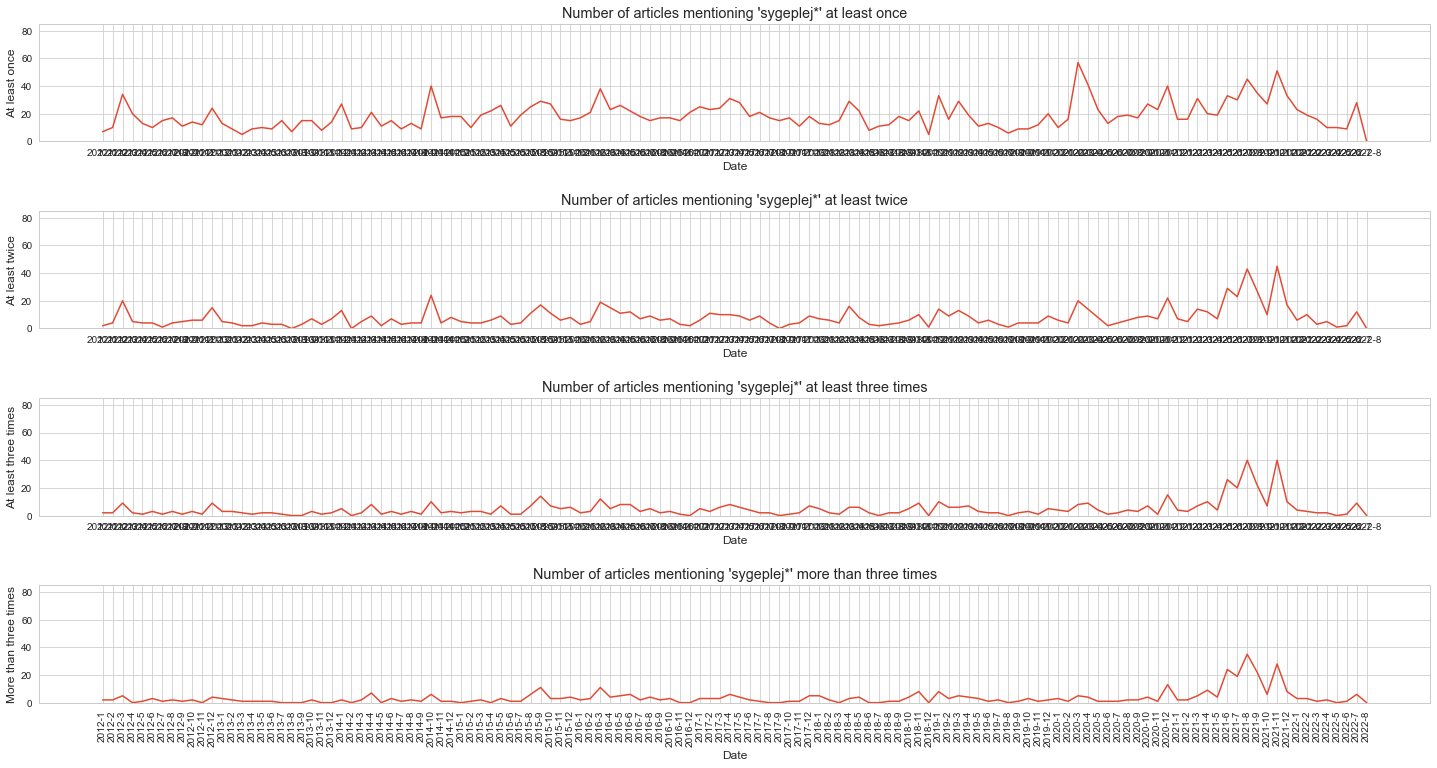

In [20]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(20,10))
fig.tight_layout(h_pad = 5)
ax[0] = sns.lineplot(x = 'Date', y = "At least once", data=tv2_freq_df, ax=ax[0])
_ = ax[0].set(ylim=(0, 85))
_ = ax[0].set_title("Number of articles mentioning 'sygeplej*' at least once")

ax[1] = sns.lineplot(x = 'Date', y = "At least twice", data=tv2_freq_df, ax=ax[1])
_ = ax[1].set(ylim=(0, 85))
_ = ax[1].set_title("Number of articles mentioning 'sygeplej*' at least twice")

ax[2] = sns.lineplot(x = 'Date', y = "At least three times", data=tv2_freq_df, ax=ax[2])
_ = ax[2].set(ylim=(0, 85))
_ = ax[2].set_title("Number of articles mentioning 'sygeplej*' at least three times")

ax[3] = sns.lineplot(x = 'Date', y = "More than three times", data=tv2_freq_df, ax=ax[3])
_ = ax[3].set(ylim=(0, 85))
_ = ax[3].set_title("Number of articles mentioning 'sygeplej*' more than three times")

_=plt.xticks(rotation=90)

It seems reasonable to take article in which our search term appears at least twice. The overall tendency is the same but becomes clearer for articles in which the term applies more frequently.

##### 3b: DR

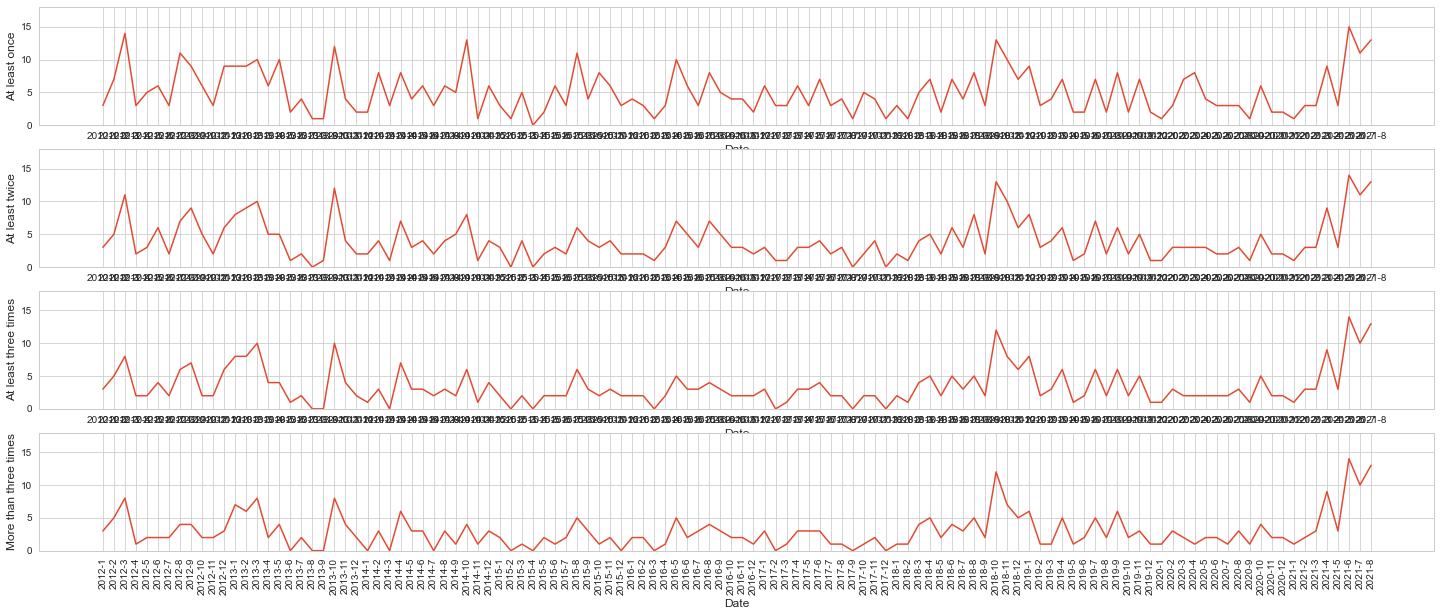

In [21]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(25,10))

ax[0] = sns.lineplot(x = 'Date', y = "At least once", data=dr_freq_df, ax=ax[0])
_ = ax[0].set(ylim=(0, 18))

ax[1] = sns.lineplot(x = 'Date', y = "At least twice", data=dr_freq_df, ax=ax[1])
_ = ax[1].set(ylim=(0, 18))

ax[2] = sns.lineplot(x = 'Date', y = "At least three times", data=dr_freq_df, ax=ax[2])
_ = ax[2].set(ylim=(0, 18))
_=plt.xticks(label=None)

ax[3] = sns.lineplot(x = 'Date', y = "More than three times", data=dr_freq_df, ax=ax[3])
_ = ax[3].set(ylim=(0, 18))

_=plt.xticks(rotation=90)

plt.show()

We see the same patterns for all articles. This could be explained by the data gathering process. We searched google and got mostly relevant articles. Even though we searched every month, we got more articles for some month and less so for others. In a way, we worked against the search engine. It would be expected that we do not find a pattern because all else equal, the line would be flat. We can reject the hypothesis that there is no development. This is particularly obvious for the corona period. 

It is interesting that for DR articles, we see the number of articles peaking at the beginning of corona crisis.

##### 3c: Folketinget

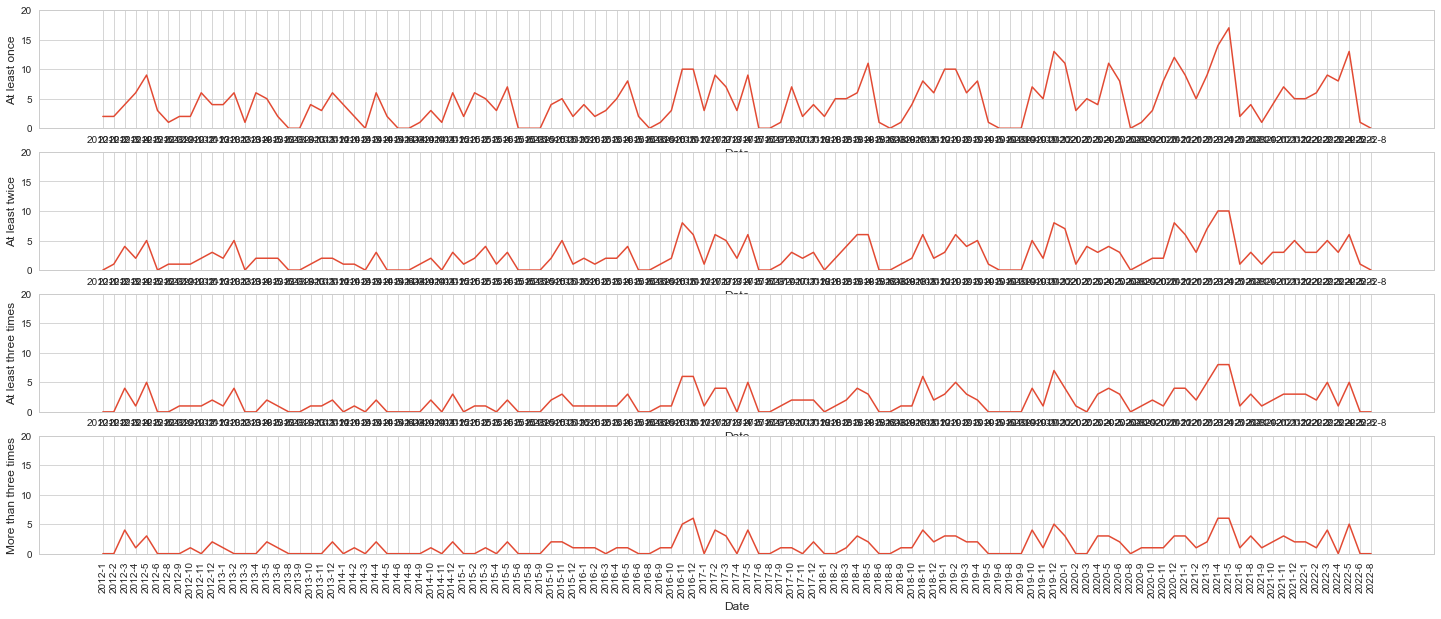

In [22]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=4, ncols=1, sharey=False, figsize=(25,10))

ax[0] = sns.lineplot(x = 'Date', y = "At least once", data=ft_freq_df, ax=ax[0])
ax[0].set(ylim=(0, 20))
ax[1] = sns.lineplot(x = 'Date', y = "At least twice", data=ft_freq_df, ax=ax[1])
ax[1].set(ylim=(0, 20))

ax[2] = sns.lineplot(x = 'Date', y = "At least three times", data=ft_freq_df, ax=ax[2])
ax[2].set(ylim=(0, 20))

ax[3] = sns.lineplot(x = 'Date', y = "More than three times", data=ft_freq_df, ax=ax[3])
ax[3].set(ylim=(0, 20))
_=plt.xticks(rotation=90)


The overall tendency is the same for all four counts of "sygeplej*". It seems that in the second half our period of interest, the term "sygeplejersk*" is generally more frequently used, even if the usage fluctuates quite alot between years.

## Analysis

### Analyzing mentions of "sygeplejersk*" in media and parliament

#### 1: Plotting number of articles that mention "sygeplejersk*" at least twice by date 

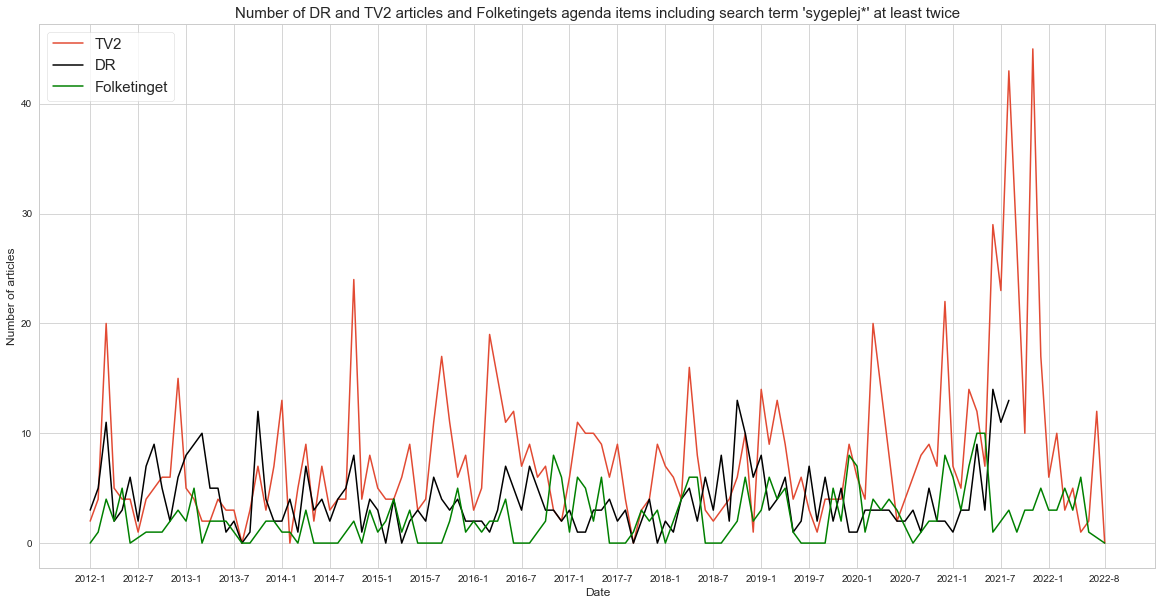

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))

sns.lineplot(x = 'Date', y = "At least twice", data=tv2_freq_df, label="TV2")
sns.lineplot(x = 'Date', y = "At least twice", data=dr_freq_df, color="black", label="DR")
sns.lineplot(x = 'Date', y = "At least twice", data=ft_freq_df, color="green", label="Folketinget")

plt.legend(fontsize=15)

_ = plt.title ("Number of DR and TV2 articles and Folketingets agenda items including search term 'sygeplej*' at least twice", fontsize=15)
_ = plt.ylabel("Number of articles")
_ = plt.xticks([0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 127])

plt.savefig("sygeplej_twice.pdf", dpi=300)
plt.show()

Something is strange in relation to the DR data. After 2021 we cannot find articles that include 'sygeplej' at least once. We checked and looked into an article without finding the term. So it could be that the word does indeed not appear. At least this is the result of the code we run on the articles we have from Jan 2022 and forward. However, this is somewhat surprising and we find this result very surprising against the background of the the development of the frequency curve in the figure. Some DR texts have a different format, so Google links to DR websites but we could not even find the term manually. The sudden stop of the curve is most probably an artefact of the Google search and a change in DR's web infrastructure. At this stage, we continue with the data we have.

Code we used to check the presence of the term 'sygeplej' in articles from 2022:
```python
Checking whether there are articles containing 'sygeplej':
dr_2022 = dr[(dr["date"].dt.year > 2021)]
dr_2022_1x = dr_2022[dr_2022['content'].str.count("sygeplej") >= 1]
dr_2022_1x

```

In [139]:
# copying relevant dataset
tv2_freq_df_year = tv2_freq_df.copy()
dr_freq_df_year = dr_freq_df.copy()
ft_freq_df_year = ft_freq_df.copy()

In [140]:
# DR
dr_freq_df_year = dr_freq_df_year[["Year", "At least twice"]]
dr_freq_df_year = dr_freq_df_year.groupby("Year")["At least twice"].sum()
# TV2
tv2_freq_df_year = tv2_freq_df_year[["Year", "At least twice"]]
tv2_freq_df_year = tv2_freq_df_year.groupby("Year")["At least twice"].sum()
# Folketinget
ft_freq_df_year = ft_freq_df_year[["Year", "At least twice"]]
ft_freq_df_year = ft_freq_df_year.groupby("Year")["At least twice"].sum()

In [142]:
# Dropping 2022 because the year is not over yet
# dr_freq_df_year = dr_freq_df_year.drop("2022")
tv2_freq_df_year = tv2_freq_df_year.drop("2022")
ft_freq_df_year = ft_freq_df_year.drop("2022")

In [143]:
dr_freq_df_year = pd.DataFrame(dr_freq_df_year)
tv2_freq_df_year = pd.DataFrame(tv2_freq_df_year)
ft_freq_df_year = pd.DataFrame(ft_freq_df_year)

In [ ]:
# Plotting yearly development
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))

sns.lineplot(x = 'Year', y = "At least twice", data = tv2_freq_df_year, color="red", label="TV2")
sns.lineplot(x = 'Year', y = "At least twice", data = dr_freq_df_year, color="black", label="DR")
sns.lineplot(x = 'Year', y = "At least twice", data = ft_freq_df_year, color="green", label="FT")

plt.legend(fontsize=15)

_ = plt.title ("Number of DR and TV2 articles and Folketingets agenda items including search term 'sygeplej*' at least twice", fontsize=15)
_ = plt.ylabel("Number of documents")

plt.savefig("sygeplej_twice_yearly.pdf", dpi=300)
plt.show()

#### 2: Analysis of Tags for DR and TV2

Defining function to count tags and return count table:

In [24]:
# Define tag-count function
def tag_count(df):
    df_tags=df["tag"].value_counts()
    df_tags=pd.DataFrame(df_tags).reset_index(drop=False)
    df_tags.columns=("tags", "count")
    return df_tags

Calling function:

In [25]:
# Call function
tv2_tags = tag_count(tv2_sygeplej2x)
dr_tags = tag_count(dr_sygeplej2x)

Plotting 10 most frequent tags

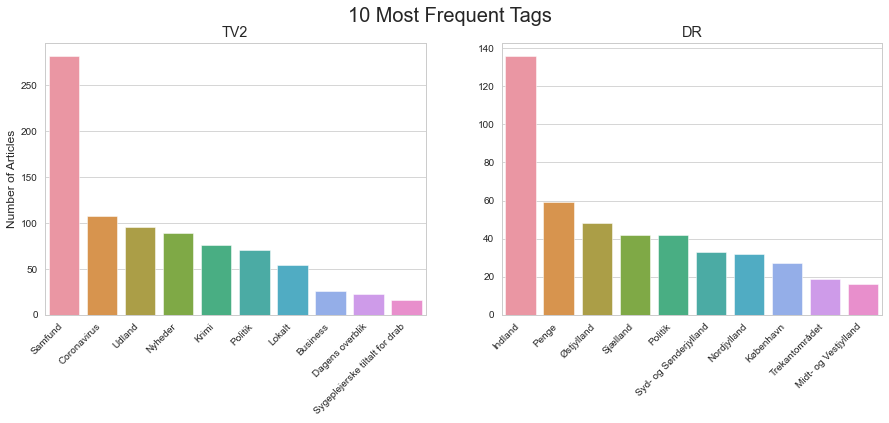

In [26]:
# Plotting count of tags
plt.style.use('ggplot')
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,5))

ax[0] = sns.barplot(x = tv2_tags["tags"][0:10], y = tv2_tags["count"], orient ="v", ax = ax[0])
ax[1] = sns.barplot(x = dr_tags["tags"][0:10], y = dr_tags["count"], orient ="v", ax = ax[1])

_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')



_ = plt.suptitle("10 Most Frequent Tags", size=20)
_ = ax[0].set_title("TV2")
_ = ax[1].set_title("DR")
_ = ax[0].set_ylabel("Number of Articles")
_ = ax[1].set_ylabel("")

_ = ax[0].set(xlabel=None)
_ = ax[1].set(xlabel=None)
plt.savefig("tags.pdf", dpi=300)

##### 2a: Analyzing "Penge" tag for dr: 

In [81]:
# Subset DataFrame
dr_penge_tag = dr_analysis[dr_analysis['tag'] == "Penge"]

In [94]:
# Group by year 
dr_penge_tag_grouped =  dr_penge_tag.groupby(dr_penge_tag["date"].dt.year)["tag"].count()

In [95]:
dr_penge_tag_grouped = pd.DataFrame(dr_penge_tag_grouped).reset_index()

In [119]:
# Read ten articles that have money as a tag in 2021
# Subset articles
dr_penge_2021 = dr_penge_tag[dr_penge_tag["year"] == 2021]

In [145]:
# Display a sample of 15 article titles and sub-headers to read for a more qualitative analysis
pd.options.display.max_colwidth = 200
display(dr_penge_2021[['titles', 'sub_header', 'date']].sample(n=30))

,titles,sub_header,date
1416,sådan kan sygeplejerskernes strejke ramme: risiko for længere ventetid til ny hofte,"strejken gælder 10 procent af de ansatte på de områder, der er varslet strejke for.",2021-04-23 11:44:00+00:00
1472,danske regioner: opsigelse fra protestsygeplejerske er et kampskridt,under navnet '#kollektivopsigelse' opfordres sygeplejersker på facebook til kollektivt at sige op i dag. men det kan være ulovligt og føre til bøder.,2021-11-30 09:47:00+00:00
1407,bombe under forhandlinger: sygeplejersker stemmer nej til ny overenskomst,det er nu op til sygeplejerådets hovedbestyrelse at beslutte næste skridt.,2021-03-25 14:22:00+00:00
1414,sygeplejersker sagde nej til overenskomst: så meget tjener de i forhold til andre fag,en gennemsnitlig sygeplejerskes løn er steget med 21 procent de seneste ti år. alligevel tjener de fortsat mindre end mandsdominerede fag.,2021-04-21 08:40:00+00:00
1431,sygeplejersker frustrerede over udsigt til lang strejke: vil have politikere til at gribe ind,"alt handler om strejke, nødberedskab, dårlig samvittighed, grædende kollegaer og følelsen af ikke at slå til, lyder det fra sygeplejersker på strejkeramt afdeling.",2021-06-30 18:38:00+00:00
1488,pensionerede sygeplejersker skal hjælpe coronapressede hospitaler: 'vi er klar - men ikke for enhver pris',"milliard skal blandt andet gå til pensionerede sygeplejersker, som skal tage en ekstra tørn under coronavinteren.",2021-12-06 19:49:00+00:00
1443,efter en måned med konflikt: sygeplejersker har ikke vundet større støtte i befolkningen,flere end en tredjedel af danskerne har fortsat ikke taget stilling til strejken.,2021-07-19 04:42:00+00:00
1420,"økonom: skal kvindefag løftes til samme lønniveau som mandefag, vil det skabe en lavine i danske lønninger","et lønløft til kvindedominerede fag i det offentlige vil koste 15-20 milliarder kroner årligt, anslår økonom.",2021-04-29 03:40:00+00:00
1401,får sygeplejerskerne en tungere lønpose? forhandlinger i sidste fase,overenskomstforhandlingerne for regionerne går i dag ind i sin afgørende fase. den største gruppe er sygeplejerskerne.,2021-02-19 10:07:00+00:00
1437,"pårørende opfordres til at hjælpe ældre og sårbare: få overblik over, hvor kommunernes sygeplejersker strejker","i 12 kommuner er sygeplejersker udtaget til strejke. det rammer både ældrepleje, sundhedspleje og plejehjem.",2021-06-16 08:48:00+00:00


 ##### 2b : Analysis of "krimi" tag for tv2

In [238]:
tv2_krimi_tag = tv2_analysis[tv2_analysis['tag'] == "Krimi"].copy()

In [241]:
# Group by year 
tv2_krimi_tag_grouped =  tv2_krimi_tag.groupby(tv2_krimi_tag["date"].dt.year)["tag"].count()

In [242]:
tv2_krimi_tag_grouped = pd.DataFrame(tv2_krimi_tag_grouped).reset_index()

In [ ]:
# Create and export plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20,10))
ax[0] = sns.lineplot(x = 'date', y = 'tag', data = tv2_krimi_tag_grouped, ax = ax[0], color = 'red')\
    .set(title = "Usage of the Tag 'Krimi' in TV2 articles over time", ylabel = "Number of Articles")
ax[1] = sns.lineplot(x = 'date', y = 'tag', data = dr_penge_tag_grouped, ax = ax[1], color = 'black')\
    .set(title = "Usage of the Tag 'Penge' in DR articles over time", ylabel = "Number of Articles")
plt.savefig("TV2_krimi_tag.pdf", dpi = 300)

In [255]:
tv2_krimi_tag_2016 = tv2_krimi_tag[tv2_krimi_tag['date'].dt.year == 2016].copy()
tv2_krimi_tag_2016.sort_values('date', ascending = True, inplace = True)
tv2_krimi_tag_2016

In [259]:
tv2_krimi_tag_2015 = tv2_krimi_tag[tv2_krimi_tag['date'].dt.year == 2015].copy()
tv2_krimi_tag_2015.sort_values('date', ascending = True, inplace = True)
tv2_krimi_tag_2015

,titles,sub_header,h2,content,author,tag,date,link,source,content_cleaned,content_prepr,relevant
2437,30-årig sygeplejerske mistænkt for endnu et drab,NaN,offentligheden vil snart få indblik,"nettet om drabsmistænkt sygeplejerske er strammet. den 30-årige sygeplejerske, der er indtil nu var sigtet for tre drab og et drabsforsøg på patienter på nykøbing falster sygehus under en nattevag...",vært på tv 2 news og station 2,Krimi,2015-08-07 16:56:46+00:00,https://nyheder.tv2.dk/krimi/2015-08-07-30-aarig-sygeplejerske-mistaenkt-for-endnu-et-drab,tv2,nettet om drabsmistænkt sygeplejerske er strammet den årige sygeplejerske der er indtil nu var sigtet for tre drab og et drabsforsøg på patienter på nykøbing falster sygehus under en nattevagt er ...,net drabsmistænk sygeplejersk stram årig sygeplejersk indtil sigt tre drab drabsforsøg patient nykøbing falst sygehus nattevag sigt endnu drab dermed kvind sigt fir drab drabsforsøg afhørt lang an...,stram årig sygeplejersk sygeplejersk stram årig indtil sigt tre liv men arbejd oprind sigt dræbt søndag mart klok arbejd årig kvind
2435,sygeplejerske sigtet for at dræbe vagns bror,NaN,"dette ved vi: nedenfor kan du læse hele live-dækningen, som tv 2's retsreporter janni pedersen, der var til stede under hele retsmødet, stod for.","- han gad ikke at leve. uanset, hvordan man vender og drejer det. det gjorde han ikke. - jeg har da tænkt på efterfølgende, at hvis hun spurgte, om han har lyst til at komme afsted, så kan det god...","wickie møller iversen, wiim@tv2.dk",Krimi,2015-08-11 15:28:02+00:00,https://nyheder.tv2.dk/krimi/2015-08-11-sygeplejerske-sigtet-for-at-draebe-vagns-bror,tv2,han gad ikke at leve uanset hvordan man vender og drejer det det gjorde han ikke jeg har da tænkt på efterfølgende at hvis hun spurgte om han har lyst til at komme afsted så kan det godt være han...,gad lev uans hvordan vend drej gjord tænk efterfølg spurg lyst kom afsted så kan godt sagt ja forbavs sig vagn yvon herskov vagn bror arn herskov ald år død sygehus nykøbing falst dag kom retsmød ...,retsmød frem årig sigt dræbt arn arn herskov årig anhold mart år dag retsmød drabssigted fængsl yder fir
2440,sygeplejerske og sosu-assistent dømt: lod livløs mand ligge i havedam,NaN,manden var væk ved hjemmebesøg anklagemyndigheden krævede højere straf,en 57-årig sygeplejerske og en 28-årig sosu-assistent er i retten i sønderborg fundet skyldige i grovere skødesløshed ved ikke at have trukket en livløs mand op af en havedam. de er idømt bødestra...,NaN,Krimi,2015-08-17 07:40:02+00:00,https://nyheder.tv2.dk/krimi/2015-08-17-sygeplejerske-og-sosu-assistent-doemt-lod-livloes-mand-ligge-i-havedam,tv2,en årig sygeplejerske og en årig sosuassistent er i retten i sønderborg fundet skyldige i grovere skødesløshed ved ikke at have trukket en livløs mand op af en havedam de er idømt bødestraf på hen...,årig sygeplejersk årig sosuassistent ret sønderborg fund skyld grov skødesløs ved truk livløs mand havedam idømt bødestraf henholdsvis kron kron mand år fund livløs ans vand havedam landsby stolbr...,årig sosuassistent ret bland andr medtiltalt sygeplejersk kom fand andr medtiltalt sygeplejersk kom fand mand vægt underordn forhold sig rik brændgaardni
2434,politiet vil ikke sige undskyld til sygeplejersker,NaN,"øverst i artiklen kan du se interviewet med vagn, som ifølge anklagemyndigheden er en af sygeplejerskens ofre.","anklagemyndigheden afviser ifølge dansk sygeplejeråd at trække en udtalelse tilbage om, at ""det ikke er usædvanligt, at sygeplejersker kan finde på at tage livet af patienter."" det oplyser grete c...",NaN,Krimi,2015-08-20 15:48:39+00:00,https://nyheder.tv2.dk/krimi/2015-08-20-politiet-vil-ikke-sige-undskyld-til-sygeplejersker,tv2,anklagemyndigheden afviser ifølge dansk sygeplejeråd at trække en udtalelse tilbage om at det ikke er usædvanligt at sygeplejersker kan finde på at tage livet af patienter det oplyser grete christ...,anklagemynd afvis ifølg dansk sygeplejeråd træk udtal tilbag usædvan sygeplejersk kan f

In [260]:
tv2_krimi_tag_2012 = tv2_krimi_tag[tv2_krimi_tag['date'].dt.year == 2012].copy()
tv2_krimi_tag_2012.sort_values('date', ascending = True, inplace = True)
tv2_krimi_tag_2012

,titles,sub_header,h2,content,author,tag,date,link,source,content_cleaned,content_prepr,relevant
118,sygeplejeråd: nej til øget sikkerhed,NaN,uddannelse skaber sikkerhed lægens tilstand er kritisk,"der skal ikke indsættes sikkerhedsvagter på landets psykiatriske afdelinger for at undgå episoder som den i odense, hvor tre hospitalsansatte er blevet udsat for et knivoverfald. sådan lyder meldi...",ritzau / jely,Krimi,2012-03-16 13:42:00+00:00,https://nyheder.tv2.dk/krimi/2012-03-16-sygeplejeraad-nej-til-oeget-sikkerhed,tv2,der skal ikke indsættes sikkerhedsvagter på landets psykiatriske afdelinger for at undgå episoder som den i odense hvor tre hospitalsansatte er blevet udsat for et knivoverfald sådan lyder melding...,indsæt sikkerhedsvag land psykiatrisk afdeling undgå episod odens tre hospitalsansat blev udsat knivoverfald lyd melding dansk sygeplejeråd følg situation odens tæt nej syn bestemt vagt afdeling n...,sygeplejeråd repræsent land men desud sikker læg to kvind to såred lig lig fortsat operationsbord uden livsfar men
98,knivmand ville ikke have medicin,NaN,fik fat i en kniv,"den 47-årige psykiatriske patient, der i formiddags stak en læge og to sygeplejersker ned på odense universitetshospital, gik amok i forbindelse med, at han skulle have sin medicin. det oplyser læ...",pmol,Krimi,2012-03-16 13:58:00+00:00,https://nyheder.tv2.dk/krimi/2012-03-16-knivmand-ville-ikke-have-medicin,tv2,den årige psykiatriske patient der i formiddags stak en læge og to sygeplejersker ned på odense universitetshospital gik amok i forbindelse med at han skulle have sin medicin det oplyser lægefagli...,årig psykiatrisk patient formiddag stak læg to sygeplejersk odens universitetshospital gik amok forbind medicin oplys lægefag direktør psykiatri region syddanmark and meinert peders ved pressemød ...,stak læg to odens universitetshospital gik forbind læg to ramt fik skæreskad båd læg ene kritisk tilstand sig
106,fyns politi: vi har god tid,NaN,NaN,"fyns politi giver sig god tid for at undgå en voldelig anholdelse af en 47-årig psykisk syg mand, der i dag stak tre ansatte ned på den lukkede psykiatriske afdeling på odense universitetshospital...","jeppe lykke hansen, jely@tv2.dk",Krimi,2012-03-16 15:51:00+00:00,https://nyheder.tv2.dk/krimi/2012-03-16-fyns-politi-vi-har-god-tid,tv2,fyns politi giver sig god tid for at undgå en voldelig anholdelse af en årig psykisk syg mand der i dag stak tre ansatte ned på den lukkede psykiatriske afdeling på odense universitetshospital to ...,fyn politi giv god tid undgå vold anhold årig psykisk syg mand dag stak tre ansat lukked psykiatrisk afdeling odens universitetshospital to ofr læg sygeplejersk befind kritisk tilstand men tredj s...,to ofr læg befind kritisk tilstand tilstand men tredj meld uden livsfar
96,tre knivofre fra ouh er opereret,NaN,angreb pludseligt med kniv ville ikke tage sin medicin,"de tre ansatte på psykiatrisk afdeling, der tidligere i dag blev overfaldet af en patient med en kniv, er nu blevet opereret. ""operationerne gik godt,"" siger direktør jens peter steensen fra odens...",jely,Krimi,2012-03-16 17:43:00+00:00,https://nyheder.tv2.dk/krimi/2012-03-16-tre-knivofre-fra-ouh-er-opereret,tv2,de tre ansatte på psykiatrisk afdeling der tidligere i dag blev overfaldet af en patient med en kniv er nu blevet opereret operationerne gik godt siger direktør jens peter steensen fra odense univ...,tre ansat psykiatrisk afdeling tid dag overfald patient kniv blev oper operation gik godt sig direktør jen pet steens odens universit hospital tre indlag intensivafdeling tilstand ene tre fortsat ...,drej læg to ifølg politi årig skår men årig stuk ans bryst ans bryst årig fik perfor bugvæg læg dernæst to læg forsøg få
107,ofre for knivmand stadig indlagt,NaN,brugte skumslukker ved anholdelse uvist hvor kniv stammer fra,"en læge og to sygeplejesker fra odense universitets hospital er fortsat indlagt, efter en psykisk syg mand i går morges overfaldt dem på hospita-lets lukkede psykiatriske afdeling. gern

# Sygeplejerske tiltalt for drab-tag

In [262]:
tv2_drab_tag = tv2_analysis[tv2_analysis['tag'] == 'Sygeplejerske tiltalt for drab'].copy()
tv2_drab_tag

#### 3: Plotting google searches for sygeplej* on DR

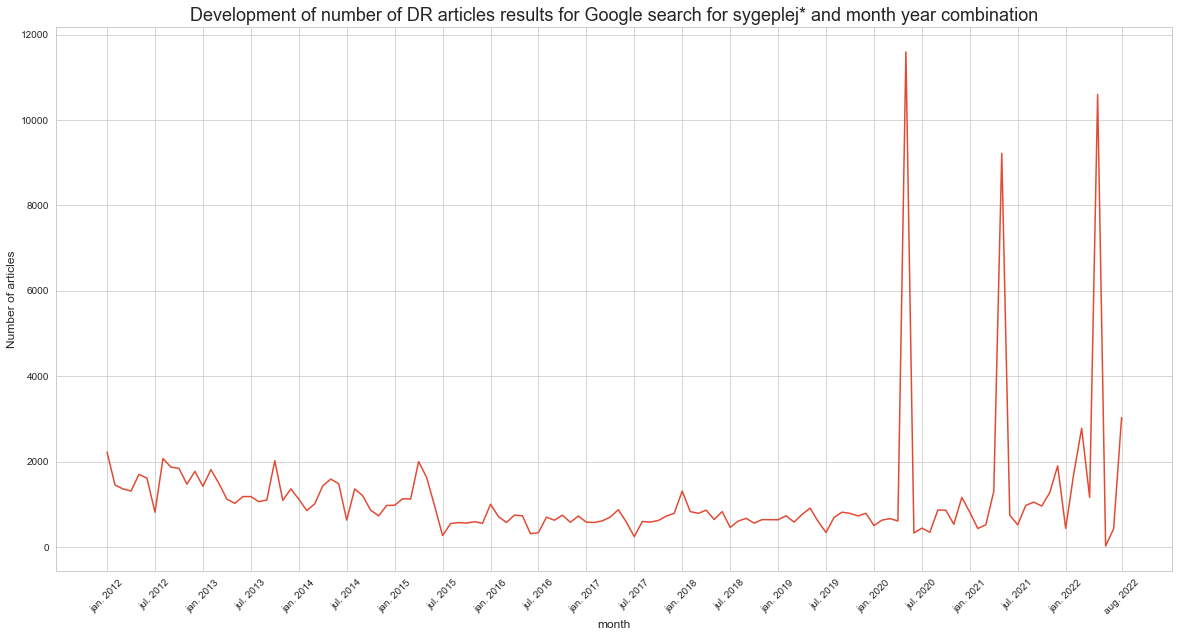

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))

sns.lineplot(x = 'month', y = 'search_results', data = dr_google_search_results)

_ = plt.title ("Development of number of DR articles results for Google search for sygeplej* and month year combination", fontsize = 18)
_ = plt.ylabel("Number of articles")
_ = plt.xticks([0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 127])
_ = plt.xticks(rotation=45)


plt.savefig("DR_sygeplej_searches.pdf", dpi=300)
plt.show()

In [28]:
dr_google_search_results = dr_google_search_results.sort_values('search_results', ascending = False)
dr_google_search_results.head(5)

,search_results,month
100,11600,maj 2020
124,10600,maj 2022
112,9220,maj 2021
127,3030,aug. 2022
122,2780,mar. 2022


In [29]:
with open('dr_months_most_searches_sygeplej.tex','w') as tf:
    tf.write(dr_google_search_results.head(5).to_latex(index=False))
with open('dr_months_least_searches_sygeplej.tex','w') as tf:
    tf.write(dr_google_search_results.tail(5).to_latex(index=False))

#### 4: Google search peak analysis

In [ ]:
# Analysis of May peaks in Google search results dataset

In [108]:
dr_analysis = pd.read_csv("dr_analysis.csv")
dr_analysis['date'] = pd.to_datetime(dr_analysis['date'])

In [124]:
# May 2020
dr_analysis_20=dr_analysis[dr_analysis['date'].dt.year == 2020]
dr_analysis_20=dr_analysis_20[dr_analysis_20['date'].dt.month == 5]

In [126]:
pd.options.display.max_colwidth = 200
display(dr_analysis_20[['titles', 'sub_header', 'h2', 'date', 'link']])

,titles,sub_header,h2,date,link
382,sygeplejersker siger stop: vores fleksibilitet bliver brugt og udnyttet,"antallet af coronapatienter kan ikke længere retfærdiggøre arbejdsforholdene, mener dansk sygeplejeråd.",bliver taget for givet erklæring gælder ikke mere forhandler ikke i medier,2020-05-02 06:25:00+00:00,https://www.dr.dk/nyheder/regionale/fyn/sygeplejersker-siger-stop-vores-fleksibilitet-bliver-brugt-og-udnyttet
383,"'tak for alt det, som i gør': hypet kunstner hylder sygeplejersker som vor tids superhelte",værket af den britiske kunstner banksy er allerede et hit på nettet.,'det her er simpelt og genialt' med til at højne moralen,2020-05-07 18:00:00+00:00,https://www.dr.dk/nyheder/kultur/tak-alt-det-som-i-goer-hypet-kunstner-hylder-sygeplejersker-som-vor-tids-superhelte
384,rift om studiepladserne til sommer: politikere opfordrer til flere studiepladser og bredere søgning,"dansk erhverv vurderer, at flere unge vil søge ind på en uddannelse til sommer. minister vil ikke fjerne uddannelsesloft.",flere studiepladser til flere ansøgere patientforening: der mangler læger og sygeplejersker større spredning fagligt og geografisk positivt med flere studerende ledige pladser på lærer- og pædagog...,2020-05-03 21:00:00+00:00,https://www.dr.dk/nyheder/indland/rift-om-studiepladserne-til-sommer-politikere-opfordrer-til-flere-studiepladser-og


In [122]:
# May 2021
dr_analysis_21=dr_analysis[dr_analysis['date'].dt.year == 2021]
dr_analysis_21=dr_analysis_21[dr_analysis_21['date'].dt.month == 5]

In [123]:
pd.options.display.max_colwidth = 200
display(dr_analysis_21[['titles', 'sub_header', 'h2', 'date']])

,titles,sub_header,h2,date
424,ekspert før sygeplejerskeforhandling: stor sandsynlighed for strejke,"det er en vanskelig situation, som vi står overfor, vurderer arbejdsmarkedsforsker.",trækker op til konflikt en svær opgave for forligsmanden fik kommission i 2008,2021-05-07 03:50:00+00:00
425,sygeplejersker ryster på hovedet over overenskomstløsning: frygter syltekrukke,"en komité skal kigge på offentligt ansattes lønninger. ""dem har vi haft nok af, lyder det fra sygeplejersker.""","- virkeligheden er, at der ikke er noget resultat gammel lønkommission spøger fagbevægelsen: et skridt i den rigtige retning",2021-05-19 03:45:00+00:00
427,"coronapukkel af patienter venter på operation og behandling: 'vi håber, de kan nås i år'","hvis sygeplejersker ender i strejke, vil det ramme samme patientgrupper, frygter hospitalsdirektør",forsøger at indhente på lørdage personalet er slidt hårdt at se på ventende patienter strejke kan øge pukler ikke et kald,2021-05-20 03:50:00+00:00


In [120]:
# May 2022
dr_analysis_22=dr_analysis[dr_analysis['date'].dt.year == 2022]
dr_analysis_22=dr_analysis_22[dr_analysis_22['date'].dt.month == 5]

In [121]:
pd.options.display.max_colwidth = 200
display(dr_analysis_22[['titles', 'sub_header', 'h2', 'date']])

,titles,sub_header,h2,date


### Preparing documents

#### 1: Removing unnecessary characters

In [30]:
def analysis_cleaner(document):
    document = re.sub(r'[^\w\s]', '', document) #Remove non-alphanumeric characters
    document = re.sub(r'[^\D+]', '', document) #Remove non-numberic characters
    document = document.replace(r'\W', ' ')\
                .replace('  ', ' ')
    return document

In [31]:
dr_analysis = dr_sygeplej2x.copy().reset_index(drop=True)
tv2_analysis = tv2_sygeplej2x.copy().reset_index(drop=True)
ft_analysis = ft_sygeplej2x.copy().reset_index(drop=True)

dr_analysis["content_cleaned"] = dr_analysis["content"].apply(analysis_cleaner)
tv2_analysis["content_cleaned"] = tv2_analysis["content"].apply(analysis_cleaner)
ft_analysis["content_cleaned"] = ft_analysis["content"].apply(analysis_cleaner)

#### 2: Add column with tokens 

In [32]:
dr_analysis['tokenized'] = dr_analysis.apply(lambda row: nltk.tokenize.word_tokenize(row["content_cleaned"]), axis = 1)
tv2_analysis['tokenized'] = tv2_analysis.apply(lambda row: nltk.tokenize.word_tokenize(row["content_cleaned"]), axis = 1)
ft_analysis['tokenized'] = ft_analysis.apply(lambda row: nltk.tokenize.word_tokenize(row["content_cleaned"]), axis = 1)

#### 3: Add preprocess column

Define function:

In [33]:
def pre_process(document):
    stemmer = SnowballStemmer("danish")
    danish_stopwords=stopwords.words("danish")
    
    document = nltk.tokenize.word_tokenize(document) # tokenize
    document = [word for word in document if not word in danish_stopwords] # delete stopwords
    document = [stemmer.stem(word) for word in document] # all stemmed words in a list
    document =' '.join(document) # joining stemmed words
    return document

Run function on datasets to create a conten_cleaned column:

In [34]:
dr_analysis["content_prepr"] = dr_analysis["content_cleaned"].apply(pre_process)
tv2_analysis["content_prepr"] = tv2_analysis["content_cleaned"].apply(pre_process)
ft_analysis["content_prepr"] = ft_analysis["content_cleaned"].apply(pre_process)

#### 4: Add a column with words within n words of sygeplejsk* in documents

Defining a function that returns the sorrounding n words for a given word:

In [35]:
def extract_surround_words(text, keyword, n):
    '''
    text : input text
    keyword : the search keyword we are looking
    n : number of words around the keyword
    '''
    surround_words=[]
    #extracting all the words from text
    words = words = re.findall(r'\w+', text)
    
    #iterate through all the words
    for index, word in enumerate(words):

        #check if search keyword matches
        if keyword in word:
            #fetch left side words
            left_side_words = words[index-n : index]
            
            #fetch right side words
            right_side_words = words[index+1 : index + n + 1]
            
            surround_words.append(left_side_words)
            surround_words.append(right_side_words)
    return surround_words

Defining a function that creates a new column with extract_surround_words function for our three datasets:

In [36]:
def find_relevant(df, word, n):
    r=[]
    for row in df["content_prepr"]:
        temp=extract_surround_words(row, word, n)
        temp_list=[]
        for i in temp:
            stems=' '.join(i)
            temp_list.append(stems)
            s=" ".join(temp_list)
        r.append(s)
    df['relevant']=r
    return df

Creating a new column with the three words before and after sygeplejersk is mentioned for each document

In [37]:
dr_analysis=find_relevant(dr_analysis, "sygeplejersk", 3)
tv2_analysis=find_relevant(tv2_analysis, "sygeplejersk", 3)
ft_analysis=find_relevant(ft_analysis, "sygeplejersk", 3)

### Word frequency analysis

#### 1: Defining function to create a Bag of Words summed table for entire source

In [38]:
def BoW(df): 
    count = CountVectorizer()
    df_array = df["content_prepr"]
    bag = count.fit_transform(df_array)
    
    count_array = bag.toarray() #Make the bag to an array
    matrix = pd.DataFrame(data=count_array,columns = count.get_feature_names())
    matrix_sum = matrix.sum().transpose()
    matrix_sum.sort_values(ascending = False, inplace = True)
    return matrix_sum

In [39]:
def BoW_relevant(df): 
    try :
        count = CountVectorizer()
        df_array = df['relevant']
        bag = count.fit_transform(df_array)

        count_array = bag.toarray()#Make the bag to an array
        matrix = pd.DataFrame(data=count_array,columns = count.get_feature_names())
        matrix_sum = matrix.sum().transpose()
        matrix_sum.sort_values(ascending = False, inplace = True)
    except:
        pass
    return matrix_sum

# Overvej om der skal være et BoW exploring afsnit eller om vi skal gå direkte til wordcloud/sentiment

#### 2: Wordcount with relevant words

In [40]:
dr_bow_rel= BoW_relevant(dr_analysis)
tv2_bow_rel = BoW_relevant(tv2_analysis)
ft_bow_rel= BoW_relevant(ft_analysis)

Export wordcount list of relevant words to latex:

In [41]:
with open('dr_bow_rel.tex','w') as tf:
    tf.write(dr_bow_rel.head(100).to_latex(index=False))
with open('tv2_bow_rel.tex','w') as tf:
    tf.write(tv2_bow_rel.head(100).to_latex(index=False))
with open('ft_bow_rel.tex','w') as tf:
    tf.write(ft_bow_rel.head(100).to_latex(index=False))

#### 3: Creating a wordcloud of relevant words for each source

Importing background :

In [42]:
red_circle=np.array(Image.open( "red_circle.png"))

Plotting the wordclouds

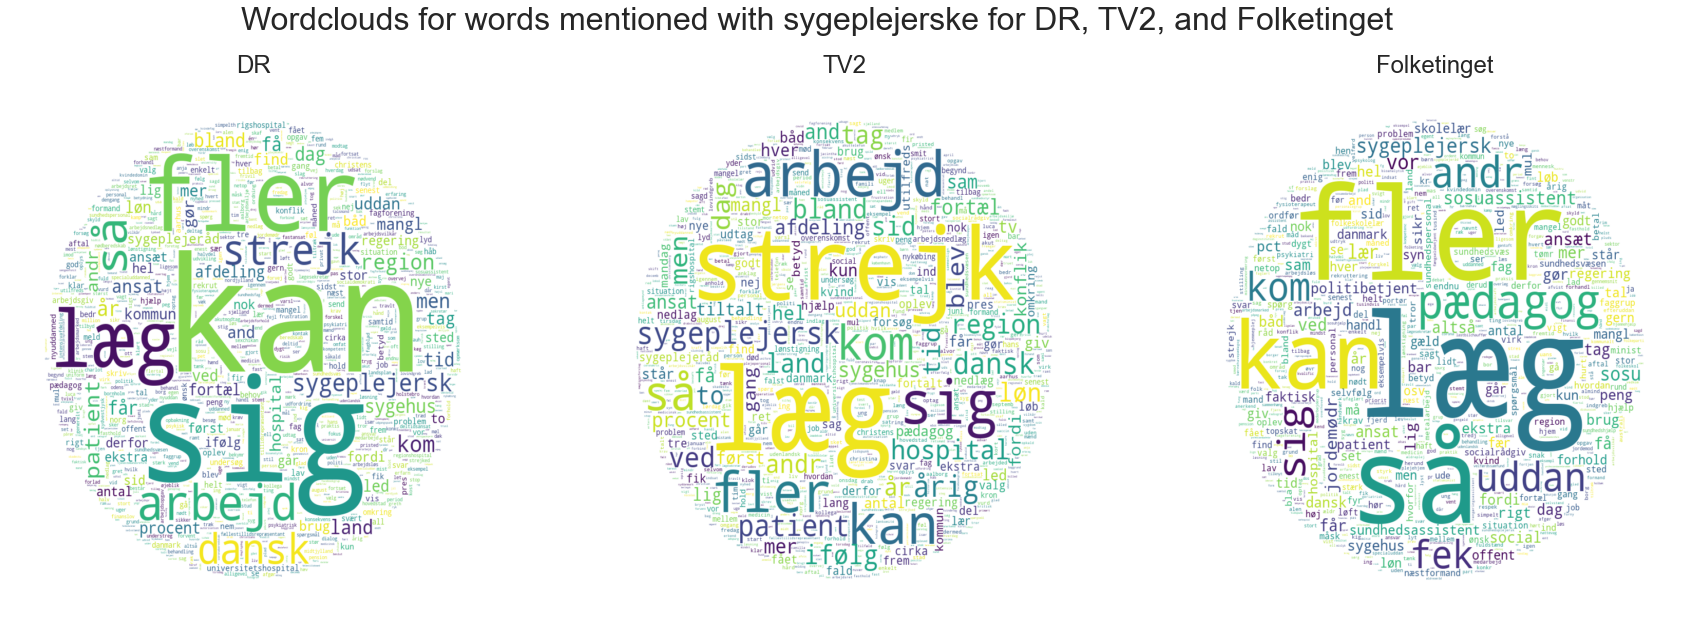

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(30,10))
_=fig.suptitle("Wordclouds for words mentioned with sygeplejerske for DR, TV2, and Folketinget", fontsize=32)
wc_dr = WordCloud(background_color="white", max_words=1000, mask=red_circle)


_=wc_dr.generate_from_frequencies(dr_bow_rel)
_=plt.subplot(1, 3, 1)
ax =plt.imshow(wc_dr, interpolation="bilinear", aspect='auto')
_=plt.axis("off")
_=plt.title("DR", fontsize=24)

_=wc_tv2 = WordCloud(background_color="white", max_words=1000, mask=red_circle)
_=wc_tv2.generate_from_frequencies(tv2_bow_rel)
_=plt.subplot(1, 3, 2)
ax =plt.imshow(wc_tv2, interpolation="bilinear", aspect='auto')
_=plt.axis("off")
_=plt.title("TV2", fontsize=24)

wc_ft = WordCloud(background_color="white", max_words=1000, mask=red_circle)
_=wc_ft.generate_from_frequencies(ft_bow_rel)
_=plt.subplot(1, 3, 3)
ax =plt.imshow(wc_ft, interpolation="bilinear", aspect='auto')
_=plt.axis("off")
_=plt.title("Folketinget", fontsize=24)

plt.savefig("wordcloud.pdf", dpi=300)

#### 3: Most used words each year for each source

Defining function to get a bow for a year:

In [44]:
def top_words(df, year):
    df_year=df[df['date'].dt.year == year]
    df_year_bow=BoW_relevant(df_year)
    return df_year_bow

Defining function to get topwords for all years for a given df:

In [45]:
def top_words_table(df, num_top_words, end_year):
    top_words_list=[]
    year_list=[]
    for year in range(2012, end_year+1,1):
        top=top_words(df, year)
        top=top[:num_top_words+1]
        top_words_list.append(top.index)
        year_list.append(year)
    top_words_df=pd.DataFrame([i for i in top_words_list], year_list).transpose()
    
        
    return top_words_df

Creating tables of top 10 words used each year for each datafram:

In [46]:
tv2_top_words=top_words_table(tv2_analysis, 10, 2022)
with open('tv2_topwords.tex','w') as tf:
    tf.write(tv2_top_words.to_latex(index=False))

ft_top_words=top_words_table(ft_analysis, 10, 2022)
with open('ft_topwords.tex','w') as tf:
    tf.write(ft_top_words.to_latex(index=False))

dr_top_words=top_words_table(dr_analysis, 10, 2021)
with open('dr_topwords.tex','w') as tf:
    tf.write(dr_top_words.to_latex(index=False))

In [47]:
def get_title_samples(df_analysis, word, year):
    df_year = df_analysis[df_analysis['date'].dt.year == year]
    df_year = df_year[df_year['relevant'].str.contains(f"{word}")]
    return df_year

In [100]:
get_title_samples(tv2_analysis, "hospital", 2020)

,titles,sub_header,h2,content,author,tag,date,link,source,content_cleaned,tokenized,content_prepr,relevant,sentiment
619,regeringen indgår aftale om 1000 flere sygeple...,regeringen og danske regioner indgår aftale om...,det bliver en stor opgave flere sygeplejersker...,regeringen leverer nu på et af socialdemokrati...,NaN,Politik,2020-01-10 14:25:28+00:00,https://nyheder.tv2.dk/politik/2020-01-10-rege...,tv2,regeringen leverer nu på et af socialdemokrati...,"[regeringen, leverer, nu, på, et, af, socialde...",regering lev socialdemokrati stor valgløft nye...,stor valgløft nye vej dansk sygehus dag aftal ...,0.100018
621,sygeplejerske advarer mod livsfarligt legetøj,"selvom legetøjet ser ufarligt ud, kan det føre...",kan koste småbørn livet flere tilfælde om ugen...,da theresa rønnebechs ældste søn fik en pakke ...,NaN,Samfund,2020-01-18 04:38:44+00:00,https://nyheder.tv2.dk/samfund/2020-01-18-syge...,tv2,da theresa rønnebechs ældste søn fik en pakke ...,"[da, theresa, rønnebechs, ældste, søn, fik, en...",theresa rønnebech ældst søn fik pak magnetkugl...,skadestu fart ifølg hvidovr hospital anja ther...,0.016068
622,dagens overblik: kæmpemeteor ramte jorden – nu...,regeringen var advaret om missilangreb. 17-åri...,advaret om missilangreb kæmpemeteor ramte jord...,velkommen til dagens overblik. da iranernes mi...,NaN,Dagens overblik,2020-01-10 19:43:24+00:00,https://nyheder.tv2.dk/2020-01-10-dagens-overb...,tv2,velkommen til dagens overblik da iranernes mis...,"[velkommen, til, dagens, overblik, da, iranern...",velkom dag overblik iran missil nat onsdag reg...,person går drøm regering dansk region plan sik...,0.032022
633,sygeplejersker i usa advarer om mangelfuld vir...,sundhedspersonalet i usa er ikke klædt på til ...,"""virkelig foruroligende"" tilbagemeldinger",den største sygeplejerskefagforening i usa adv...,NaN,Coronavirus,2020-03-06 04:49:55+00:00,https://nyheder.tv2.dk/udland/2020-03-06-sygep...,tv2,den største sygeplejerskefagforening i usa adv...,"[den, største, sygeplejerskefagforening, i, us...",størst sygeplejerskefagforening usa advar foru...,usa advar foruro coronavirus hospital klinik ...,-0.039614
638,se billederne: tætpakkede busser vækker bekymring,allerede onsdag vil ekstra busser blive sat in...,færre afgange skal sikre driften sundhedsperso...,vil man undgå at blive smittet med coronavirus...,NaN,Coronavirus,2020-03-31 18:37:36+00:00,https://nyheder.tv2.dk/samfund/2020-03-31-se-b...,tv2,vil man undgå at blive smittet med coronavirus...,"[vil, man, undgå, at, blive, smittet, med, cor...",undgå smit coronavirus god idé hold afstand an...,andr bus læg hovedstad lig let myldretid mia h...,0.054901
639,om få dage kan danmark være løbet tør for mask...,lægemiddelstyrelsen er i øjeblikket i kontakt ...,største udfordring lige nu breder sig som ring...,ikke bare risikerer danmark at løbe tør for væ...,NaN,Coronavirus,2020-03-23 12:10:27+00:00,https://nyheder.tv2.dk/samfund/2020-03-23-om-f...,tv2,ikke bare risikerer danmark at løbe tør for væ...,"[ikke, bare, risikerer, danmark, at, løbe, tør...",bar risik danmark løb tør værnemidl mask bril ...,hospital hold læg and sundhedspersonal rask to...,0.028121
644,overlæger: hospitaler trodser anbefalinger fra...,"overlægeforeningen kritiserer hospitaler, som ...",sker i flere regioner dansk sygeplejeråd har o...,"hospitaler laver stadig operationer i danmark,...",NaN,Samfund,2020-03-19 17:14:36+00:00,https://nyheder.tv2.dk/samfund/2020-03-19-over...,tv2,hospitaler laver stadig operationer i danmark ...,"[hospitaler, laver, stadig, operationer, i, da...",hospital lav stad operation danmark nødvend ly...,region tv talt overlæg gentoft hospital,0.010772
646,"mette frederiksen roses i italien, der nu skim...","italiensk mediebringer en liste over, hvordan ...",topper liste et lyspunkt i mørket,statsminister mette frederiksen (s) bliver man...,NaN,Coronavirus,2020-03-30 12:06:05+00:00,https://nyheder.tv2.dk/udland/2020-03-30-mette...,tv2,statsminister mette frederiksen s bliv

### Sentiment analysis

#### 1: Defining sentiment analysis function and appending sentiment column to df

In [73]:
def sentida_values(df): 
    sentida_preds = []

    for i, row in tqdm.tqdm(df.iterrows()):
        score = Sentida().sentida(row.content_cleaned, output = 'mean', normal = True)
        sentida_preds.append(score)
    
    return sentida_preds

In [74]:
def sentiment_column(df):
    sentida_preds = sentida_values(df)
    df['sentiment'] = sentida_preds # create new column: sentime

#### 2: Finding 100 words near words that contain 'sygeplejersk' to be used for FT

In [75]:
def extract_surround_words(text, keyword, n):
    '''
    text : input text
    keyword : the search keyword we are looking
    n : number of words around the keyword
    '''
    surround_words=[]
    #extracting all the words from text
    words = words = re.findall(r'\w+', text)
    
    #iterate through all the words
    for index, word in enumerate(words):

        #check if search keyword matches
        if keyword in word:
            #fetch left side words
            left_side_words = words[index-n : index]
            
            #fetch right side words
            right_side_words = words[index+1 : index + n + 1]
            
            surround_words.append(left_side_words)
            surround_words.append(right_side_words)
    return surround_words

In [76]:
def find_relevant_sen(df, word, n):
    r=[]
    for row in df["content_cleaned"]:
        temp=extract_surround_words(row, word, n)
        temp_list=[]
        for i in temp:
            stems = ' '.join(i)
            temp_list.append(stems)
        s = " ".join(temp_list)
        r.append(s)
        s = ""
    df['relevant_sen']=r
    return df

#### 3: Sentiment analysis on dr and tv2

In [77]:
sentiment_column(dr_analysis) # dr: create sentiment values and append to new sentiment column

495it [00:11, 41.75it/s]


In [78]:
sentiment_column(tv2_analysis) # tv2: create sentiment values and append to new sentiment column

1008it [01:00, 16.62it/s]


#### 4: Sentiment analysis of ft

In [90]:
ft_analysis = find_relevant_sen(ft_analysis, "sygeplej", 100) # searching for words close to 'sygeplej'

In [91]:
sentida_preds_ft = []

for i, row in tqdm.tqdm(ft_analysis.iterrows()):
    score = Sentida().sentida(row.relevant_sen, output = 'mean', normal = True)
    sentida_preds_ft.append(score) # create sentiment values
    
ft_analysis['sentiment'] = sentida_preds_ft # # ft: append to new sentiment column

296it [03:15,  1.51it/s]


#### 5: Plot

In [92]:
df_sentiment = pd.concat([dr_analysis, tv2_analysis, ft_analysis], ignore_index=True) # new complete df

In [93]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], utc=True) # datetime format

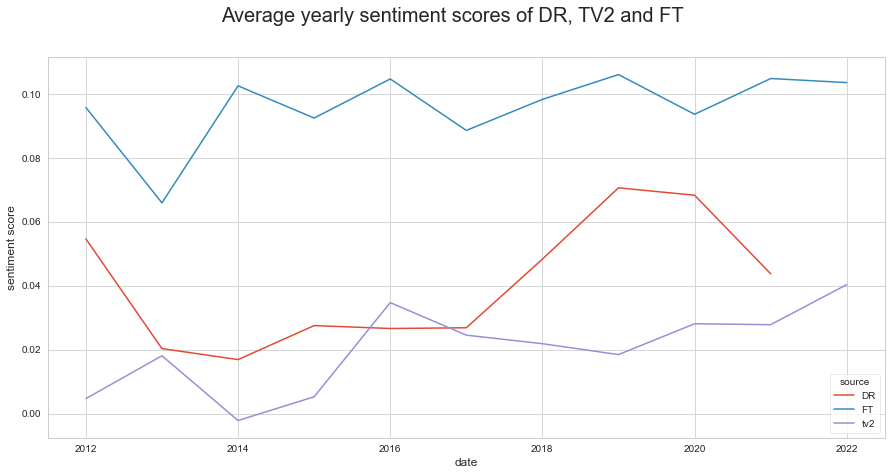

In [94]:
fig, ax = plt.subplots(figsize=(15,7))
df_sentiment.groupby([df_sentiment.date.dt.year, 'source']).mean()['sentiment'].unstack().plot(ax=ax)

plt.suptitle("Average yearly sentiment scores of DR, TV2 and FT", size=20)
ax.set_ylabel("sentiment score")
ax.set_xlabel("date")

plt.savefig("sentiment_average_comparison.pdf", dpi=300)

## Final dataframes

In [97]:
dr_analysis

,titles,sub_header,h2,content,author,tag,date,link,source,content_cleaned,tokenized,content_prepr,relevant,sentiment
0,danske sygeplejersker får job i norge,"krise, fyringer og ansættelsesstop får sygeple...",markant flere,"antallet af danske sygeplejersker, der har fåe...",ritzau/,Penge,2012-01-19 13:27:00+00:00,https://www.dr.dk/nyheder/penge/danske-sygeple...,DR,antallet af danske sygeplejersker der har fået...,"[antallet, af, danske, sygeplejersker, der, ha...",antal dansk sygeplejersk fået autorisation nor...,fået autorisation norg fyring ansættelsesstop...,0.057407
1,næsten ingen ledige sygeplejersker,trods fyringsrunder i både 2010 og 2011 er arb...,NaN,trods fyringsrunder på sygehusene i både 2010 ...,henny mortensen,Sjælland,2012-01-28 07:42:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,trods fyringsrunder på sygehusene i både og og...,"[trods, fyringsrunder, på, sygehusene, i, både...",trod fyringsrund sygehus båd nedlæg sygehus fa...,så få arbejdsløs region sjælland senest sted h...,0.013529
2,regionsformand: jeg har ikke noget at undskylde,"steen bach nielsen forstår ikke, at sygeplejer...",NaN,der er ikke noget at undskylde eller beklage.....,jørgen hansen,Sjælland,2012-01-24 15:39:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,der er ikke noget at undskylde eller beklage f...,"[der, er, ikke, noget, at, undskylde, eller, b...",undskyld beklag formand region sjælland steen ...,stærk opfordredelokalt ansat samarbejd sted di...,-0.010551
3,sygeplejersker vil skære i nattevagter,risiko for at natarbejde er kræftfremkaldende ...,færre nattevagter fast døgnrytme er vigtig,"dansk sygeplejeråd, der repræsenterer landets ...",ritzau,Indland,2012-02-21 10:48:00+00:00,https://www.dr.dk/nyheder/indland/sygeplejersk...,DR,dansk sygeplejeråd der repræsenterer landets o...,"[dansk, sygeplejeråd, der, repræsenterer, land...",dansk sygeplejeråd repræsent land omkring syge...,repræsent land omkring men mul medarbejd råd h...,-0.006787
4,udenlandske sygeplejersker er taget hjem,det er slut med sygeplejerudtryk på gebrokkent...,NaN,det er slut med sygeplejerudtryk på gebrokkent...,mikkel from nielsen,Nordjylland,2012-02-27 15:26:00+00:00,https://www.dr.dk/nyheder/regionale/nordjyllan...,DR,det er slut med sygeplejerudtryk på gebrokkent...,"[det, er, slut, med, sygeplejerudtryk, på, geb...",slut sygeplejerudtryk gebrokkent dansk nordjys...,måt sygehus import tyskland sid bespar betyd l...,0.080297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,læger og sygeplejersker siger stop: 'kan ikke ...,"ifølge ansatte på holbæk sygehus, så er forhol...",besøg fra arbejdstilsynet klare krav,"det er ikke kun sygeplejersker, der flygter fr...",trine warrer juul,Sjælland,2021-12-06 04:55:00+00:00,https://www.dr.dk/nyheder/regionale/sjaelland/...,DR,det er ikke kun sygeplejersker der flygter fra...,"[det, er, ikke, kun, sygeplejersker, der, flyg...",kun sygeplejersk flygt region sjælland sygehus...,flygt region sjælland sign fuglesang lars ven...,-0.039040
491,detektor: talsperson erkender - har ikke tal p...,talsperson for opsigelser blandt sygeplejerske...,debatindlæg som dokumenation sundhedsøkonom: '...,"- patienter ligger på gangene og dør, fordi de...",august stenbroen,Detektor,2021-12-22 19:39:00+00:00,https://www.dr.dk/nyheder/detektor/detektor-ta...,DR,patienter ligger på gangene og dør fordi de i...,"[patienter, ligger, på, gangene, og, dør, ford...",patient lig gang dør fordi tils sagd luca pris...,sundhedsvæs luca pristed talsmand national gru...,-0.094334
492,flere sygeplejersker skifter til det private: ...,der skal gøres noget ved løn og vilkår i det o...,fik hjertebanken sygeplejerskerne siger fra ’i...,"højere løn og bedre arbejdstider. det var det,...",allan nisgaard,Indland,2021-12-29 04:46:00+00:00,https://www.dr.dk/nyheder/indland/flere-sygepl...,DR,højere løn og bedre arbejdstider det var det s...,"[højere, løn, og, bedre, arbejdstider, det, va...",høj løn bedr arbejdstid fik syg

In [98]:
tv2_analysis

,titles,sub_header,h2,content,author,tag,date,link,source,content_cleaned,tokenized,content_prepr,relevant,sentiment
0,på jagt efter danske sygeplejersker,NaN,"dansk sygeplejeråd: ""what a waste"" flere sygep...","mens nyuddannede, danske sygeplejersker har me...","natali braagaard, nabr@tv2.dk",Nyheder,2012-01-27 04:57:00+00:00,https://nyheder.tv2.dk/2012-01-27-paa-jagt-eft...,tv2,mens nyuddannede danske sygeplejersker har mer...,"[mens, nyuddannede, danske, sygeplejersker, ha...",men nyuddanned dansk sygeplejersk mer svært ve...,men nyuddanned dansk mer svært ved jobtilbud d...,0.135789
1,danske sygeplejersker får job i norge,NaN,NaN,"antallet af danske sygeplejersker, der har fåe...",ritzau/meng,Business,2012-01-19 12:38:23+00:00,https://nyheder.tv2.dk/business/2012-01-19-dan...,tv2,antallet af danske sygeplejersker der har fået...,"[antallet, af, danske, sygeplejersker, der, ha...",antal dansk sygeplejersk fået autorisation nor...,fået autorisation norg fyring ansættelsesstop...,0.057407
2,kræver værter fyret efter royal joke,NaN,NaN,to australske radioværter får ikke lov til at ...,ritzau / mkij,Udland,2012-12-08 01:49:00+00:00,https://nyheder.tv2.dk/udland/2012-12-08-kraev...,tv2,to australske radioværter får ikke lov til at ...,"[to, australske, radioværter, får, ikke, lov, ...",to australsk radiovært får lov vend tilbag sen...,lig foreløb narred britisk hospital prin indla...,-0.116758
3,fortryder vi på dødslejet?,NaN,de fem fortrydelser vi fortryder ikke når frem...,"det siges, at døende mennesker får en klarhed,...","katrine bøg larsen, kabp@tv2.dk",NaN,2012-02-03 13:00:00+00:00,https://livsstil.tv2.dk/2012-02-03-fortryder-v...,tv2,det siges at døende mennesker får en klarhed n...,"[det, siges, at, døende, mennesker, får, en, k...",sig døend mennesk får klar lig yderst klar ind...,gjort anderled australsk special palliativ ple...,0.138709
4,papirer tager tid fra patienter,NaN,NaN,danske sygeplejersker laver papirmæssigt dobbe...,kasj,Nyheder,2012-02-08 11:47:58+00:00,https://nyheder.tv2.dk/2012-02-08-papirer-tage...,tv2,danske sygeplejersker laver papirmæssigt dobbe...,"[danske, sygeplejersker, laver, papirmæssigt, ...",dansk sygeplejersk lav papirmæs dobbeltarbejd ...,lav papirmæs dobbeltarbejd underudvikled comp...,0.098889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,få ansøgere på velfærdsuddannelserne: hver dag...,ikke siden 2012 har uddannelserne til sygeplej...,umuligt at finde uddannede pædagoger en nedadg...,hver dag frygter bjarne kofoed at møde ind til...,NaN,Samfund,2022-07-06 08:38:28+00:00,https://nyheder.tv2.dk/samfund/2022-07-06-faa-...,tv2,hver dag frygter bjarne kofoed at møde ind til...,"[hver, dag, frygter, bjarne, kofoed, at, møde,...",hver dag frygt bjarn kofoed mød opsig anmodnin...,velfærdsuddan sid uddan pædagog socialrådgiv l...,0.061599
1004,tallene er tydelige: de unge vil ikke læse ude...,de unges ønsker stemmersimpelthen ikke overens...,en tikkende bombe stemmer ikke overens nøglen ...,der er sket et markant fald i antallet af velf...,NaN,Samfund,2022-07-28 06:58:29+00:00,https://nyheder.tv2.dk/samfund/2022-07-28-tall...,tv2,der er sket et markant fald i antallet af velf...,"[der, er, sket, et, markant, fald, i, antallet...",sket markant fald antal velfærdsstud hel land ...,optagn velfærdsuddan dæk pædagog socialrådgiv ...,0.080921
1005,"dagens overblik: finner er vrede over, at russ...",en kompagnichef fortæller om flere krænkelser ...,finner vil ikke lade russere rejse ind på feri...,jonas vingegaard har muligvis for første gang ...,NaN,Dagens overblik,2022-07-29 18:46:26+00:00,https://nyheder.tv2.dk/2022-07-29-dagens-overb...,tv2,jonas vingegaard har muligvis for første gang ...,"[jonas, vingegaard, har, muligvis, for, første...",jona vingegaard muligvis først gang fredag sid...,halvdel opslåed stilling social sundhedsassist...,-0.004534
1006,"danskere splittede i sas-konflikt, men enige o...",81 procent af danskerne ønsker ikke at booke b...,fravælger sas,"det er 

In [99]:
ft_analysis

,session,meetingnumber,date,location,group,content,path,source,content_cleaned,tokenized,content_prepr,relevant,relevant_sen,sentiment
0,20111,102,2012-09-13,Folketingssalen,Folketinget,det næste punkt på dagsordenen er: 3) 3. behan...,/ODAXML/Referat/samling/20111/20111_M102_helem...,FT,det næste punkt på dagsordenen er behandling ...,"[det, næste, punkt, på, dagsordenen, er, behan...",næst punk dagsorden behandling lovforslag nr l...,fabriksarbejd rengøringsassistent metalarbejd ...,fokus for med den her skattereform belønner vi...,0.117528
1,20111,48,2012-02-21,Folketingssalen,Folketinget,det sidste punkt på dagsordenen er: 17) foresp...,/ODAXML/Referat/samling/20111/20111_M48_helemo...,FT,det sidste punkt på dagsordenen er forespørgse...,"[det, sidste, punkt, på, dagsordenen, er, fore...",sidst punk dagsorden forespørgsel nr f forespø...,ansæt fler sosu gansk enkelt led sundhedsassis...,en markant ændring i befolkningssammensætninge...,0.165444
2,20111,57,2012-03-14,Folketingssalen,Folketinget,det sidste punkt på dagsordenen er: 2) besvare...,/ODAXML/Referat/samling/20111/20111_M57_helemo...,FT,det sidste punkt på dagsordenen er besvarelse ...,"[det, sidste, punkt, på, dagsordenen, er, besv...",sidst punk dagsorden besvar oversend spørgsmål...,ved udlændingepolitik årig australi kan få nok...,er som justitsminister som sagt glad for at de...,0.127770
3,20111,58,2012-03-20,Folketingssalen,Folketinget,det næste punkt på dagsordenen er: 20) 1. beha...,/ODAXML/Referat/samling/20111/20111_M58_helemo...,FT,det næste punkt på dagsordenen er behandling ...,"[det, næste, punkt, på, dagsordenen, er, behan...",næst punk dagsorden behandling lovforslag nr l...,danmark sig årig australi ønsk kom nye regl år...,vendt indvandringen til danmark på en måde så ...,0.130313
4,20111,62,2012-03-27,Folketingssalen,Folketinget,det sidste punkt på dagsordenen er: 11) forhan...,/ODAXML/Referat/samling/20111/20111_M62_helemo...,FT,det sidste punkt på dagsordenen er forhandling...,"[det, sidste, punkt, på, dagsordenen, er, forh...",sidst punk dagsorden forhandling redegør nr r ...,pædagog folkeskolelær socialrådgiv altså hvord...,på vej kunne det være man også skulle have dem...,0.165910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,20211,84,2022-03-31,Folketingssalen,Folketinget,det næste punkt på dagsordenen er: 8) forhandl...,/ODAXML/Referat/samling/20211/20211_M84_helemo...,FT,det næste punkt på dagsordenen er forhandling ...,"[det, næste, punkt, på, dagsordenen, er, forha...",næst punk dagsorden forhandling redegør nr r m...,hel debat tjenestemandsreform strejk virk sat ...,er det jeg forholder mig til her i talen forma...,0.090617
292,20211,84,2022-03-31,Folketingssalen,Folketinget,det sidste punkt på dagsordenen er: 13) foresp...,/ODAXML/Referat/samling/20211/20211_M84_helemo...,FT,det sidste punkt på dagsordenen er forespørgse...,"[det, sidste, punkt, på, dagsordenen, er, fore...",sidst punk dagsorden forespørgsel nr f forespø...,sundhedsminist hvilk rol strejk indgreb forske...,om hvordan vi rekrutterer og fastholder person...,0.109078
293,20211,86,2022-04-05,Folketingssalen,Folketinget,det næste punkt på dagsordenen er: 5) udvidet ...,/ODAXML/Referat/samling/20211/20211_M86_helemo...,FT,det næste punkt på dagsordenen er udvidet part...,"[det, næste, punkt, på, dagsordenen, er, udvid...",næst punk dagsorden udvid partilederdebat form...,pædagog pædagogisk assistent set gern løft sek...,fru pia olsen dyhr så bekræfte at forudsætning...,0.031185
294,20211,86,2022-04-05,Folketingssalen,Folketinget,det sidste punkt på dagsordenen er: 6) 1. beha...,/ODAXML/Referat/samling/20211/20211_M86_helemo...,FT,det sidste punkt på dagsordenen er behandling...,"[det, sidste, punkt, på, dagsordenen, er, beha...",sidst punk dagsorden behandling lovforslag nr ...,godt nyt børnefamili får tillæg pension velfær...,der er vurderingen jo at staten ikke kommer ti...,0.185506


In [96]:
dr_analysis.to_csv("dr_analysis.csv", index=False)
tv2_analysis.to_csv("tv2_analysis.csv", index=False)
ft_analysis.to_csv("ft_analysis.csv.zip", index=False, compression="zip")